# Face Generation
## Parameter Evaluation
### <a href='#Parameter_n_epochs'>Parameter: n_epochs</a>
### <a href='#Parameter_number_conv_deconv_layers'>Parameter: number of conv-layers and deconv-layers</a>
### <a href='#Parameter_conv_dim'>Parameter: conv_dim</a>
### <a href='#Parameter_lr'>Parameter: lr</a>
### <a href='#Parameter_batch_size'>Parameter: batch_size</a>
### <a href='#Parameter_beta1'>Parameter: beta1</a>
### <a href='#Parameter_dropout'>Parameter: Dropout config</a>

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data
Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [73]:
#!pip install --upgrade pip
#!pip install torch
#!pip install torchvision
#!pip install -U numpy
#!pip show numpy

In [3]:
# necessary imports
import pandas as pd
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image 
import glob
import os

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# can comment out after executing
!unzip processed_celeba_small.zip 

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests


%matplotlib inline

In [5]:
# Parameter settings

train_n = 43
param = 'drop'

# set parameter sets
number_epochs = [1, 10, 50, 100, 500, 1000]
lr_set = [0.0002]
batch_size_set = [32]
conv_dim_set = [64, 128, 256]

# default
batch_size = 32
img_size = 32
n_epochs = 101
conv_dim = 64
lr = 0.0002
beta1=0.2
beta2=0.999
z_size = 100

In [6]:
# Make directories if they do not exist
data_dir_2 = './training_results_pkl'
if not os.path.exists(data_dir_2):
    os.makedirs(data_dir_2)
    
data_dir_2 = './training_results'
if not os.path.exists(data_dir_2):
    os.makedirs(data_dir_2)
    
data_dir_2 = './image_sets'
if not os.path.exists(data_dir_2):
    os.makedirs(data_dir_2)

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [7]:
print('Number of images used for the Discriminator Training: ', len(glob.glob("processed_celeba_small/celeba/*.jpg")))

Number of images used for the Discriminator Training:  32600


In [6]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # Tensor transform
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()
                                    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

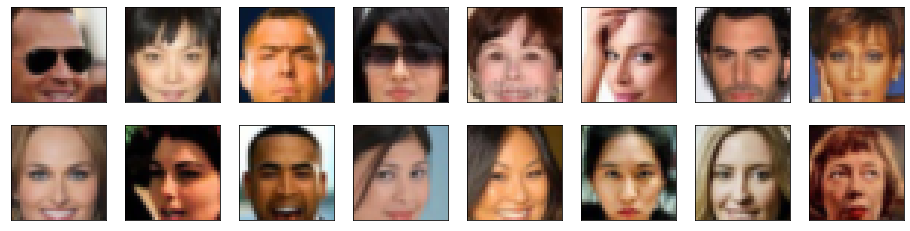

In [13]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(16, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [14]:
fig.savefig('image_sets/orig_examples.png')

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [11]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
     # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x
    

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.6863)
Max:  tensor(0.7882)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [13]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [15]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
        # set dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        #out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out), 0.2)
        #out = self.dropout(out)
        out = F.leaky_relu(self.conv3(out), 0.2)
        #out = self.dropout(out)
        out = F.leaky_relu(self.conv4(out), 0.2)
        # flatten
        out = out.view(-1, self.conv_dim*8*2*2)
        #out = self.dropout(out)
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [14]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [16]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        # set dropout layer
        self.dropout = nn.Dropout(p=0.5)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 2, 2)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        #out = self.dropout(out)
        out = F.relu(self.t_conv2(out))
        #out = self.dropout(out)
        out = F.relu(self.t_conv3(out))
        #out = self.dropout(out)
        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [17]:
# takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)
    
    elif hasattr(m, 'weight') and classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [19]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [20]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9 # smooth, real labels = 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models.

In [21]:
# Create optimizers for the discriminator and generator
def optimizer(lr):
    d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

    return d_optimizer, g_optimizer

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
# save chosen hyperparameters of the actual training run to an excel file
def save_data(index, losses, batch_size):
    losses = np.array(losses)
    
    # Export Loss as Dataframe
    idx = range(len(losses.T[0]))
    d = {'Discriminator': losses.T[0], 'Generator': losses.T[1]}
    loss_df = pd.DataFrame(data=d, index = idx)
    train_number = train_n + index
    loss_df.to_excel('training_results/train_' + str(train_number) +'_'+ param + ".xlsx")
    
    # Export hyperparameters
    hyper_params = {'batch_size': batch_size,
                'img_size': img_size,
                'deconv-layers': 3,
                'conv-layers': 3,
                'd_conv_dim': d_conv_dim,
                'g_conv_dim': g_conv_dim,
                'z_size': z_size,
                'lr': lr,
                'beta1': beta1,
                'beta2': beta2,
                'dropout': 'no',
                'n_epochs': n_epochs
                }
    hyper_param_df = pd.DataFrame.from_dict(hyper_params, orient='index')
    hyper_param_df.to_excel('training_results/train_' + str(train_number) +'_'+ param + "_hyper_param.xlsx")
    print(hyper_params)

In [23]:
# plot the training losses of Discriminator and Generator for the actual training run
def plot_training_loss(losses):
    print('Plot Loss')
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(index, epoch):
    print('View Samples')
    train_number = train_n + index
    # Load samples from generator, taken while training
    with open('training_results_pkl/train_' + str(train_number) +'_'+ param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[-1]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [25]:
def train(D, G,  n_epochs, index=0, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    train_number = train_n + index
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

        if epoch % 10 == 0:
            # Save training generator samples
            with open('training_results_pkl/train_' + str(train_number) +'_'+ param + '_' + str(epoch) + '_samples.pkl', 'wb') as f:
                pkl.dump(samples, f)
                
            _ = view_samples(index, epoch)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/    1] | d_loss: 1.3957 | g_loss: 2.4632
Epoch [    1/    1] | d_loss: 0.2853 | g_loss: 4.9780
Epoch [    1/    1] | d_loss: 0.6203 | g_loss: 5.6454
Epoch [    1/    1] | d_loss: 0.4077 | g_loss: 3.1046
Epoch [    1/    1] | d_loss: 0.6913 | g_loss: 1.2176
Epoch [    1/    1] | d_loss: 0.8637 | g_loss: 1.3697
Epoch [    1/    1] | d_loss: 0.7251 | g_loss: 2.6770
Epoch [    1/    1] | d_loss: 0.8540 | g_loss: 3.1790
Epoch [    1/    1] | d_loss: 1.2345 | g_loss: 0.8898
Epoch [    1/    1] | d_loss: 0.7317 | g_loss: 1.4443
Epoch [    1/    1] | d_loss: 0.8113 | g_loss: 2.5183
Epoch [    1/    1] | d_loss: 0.8521 | g_loss: 1.0809
Epoch [    1/    1] | d_loss: 0.8911 | g_loss: 1.1448
Epoch [    1/    1] | d_loss: 0.8050 | g_loss: 1.5601
Epoch [    1/    1] | d_loss: 0.9884 | g_loss: 2.3249
Epoch [    1/    1] | d_loss: 0.8494 | g_loss: 1.6558
Epoch [    1/    1] | d_loss: 0.8317 | g_loss: 1.4598
Epoch [    1/    1] | d_loss: 0.7504 | g_loss: 1.6912
Epoch [    1/    1] | d_loss

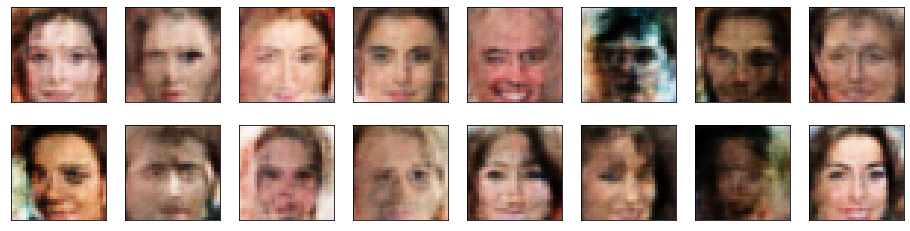

In [36]:
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
n_epochs=1
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, ke

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  101] | d_loss: 1.3132 | g_loss: 1.8226
Epoch [    1/  101] | d_loss: 0.2894 | g_loss: 5.8060
Epoch [    1/  101] | d_loss: 1.0787 | g_loss: 8.8052
Epoch [    1/  101] | d_loss: 0.8208 | g_loss: 1.3576
Epoch [    1/  101] | d_loss: 1.1760 | g_loss: 4.4962
Epoch [    1/  101] | d_loss: 1.3159 | g_loss: 2.1459
Epoch [    1/  101] | d_loss: 0.7045 | g_loss: 3.5985
Epoch [    1/  101] | d_loss: 1.0629 | g_loss: 3.1653
Epoch [    1/  101] | d_loss: 0.6474 | g_loss: 2.6862
Epoch [    1/  101] | d_loss: 1.0216 | g_loss: 3.3642
Epoch [    1/  101] | d_loss: 0.8806 | g_loss: 2.5336
Epoch [    1/  101] | d_loss: 1.1234 | g_loss: 0.8005
Epoch [    1/  101] | d_loss: 0.6499 | g_loss: 2.6747
Epoch [    1/  101] | d_loss: 0.7951 | g_loss: 1.9073
Epoch [    1/  101] | d_loss: 0.6942 | g_loss: 1.1463
Epoch [    1/  101] | d_loss: 0.5534 | g_loss: 1.2706
Epoch [    1/  101] | d_loss: 0.8283 | g_loss: 2.8099
Epoch [    1/  101] | d_loss: 1.6730 | g_loss: 0.5402
Epoch [    1/  101] | d_loss

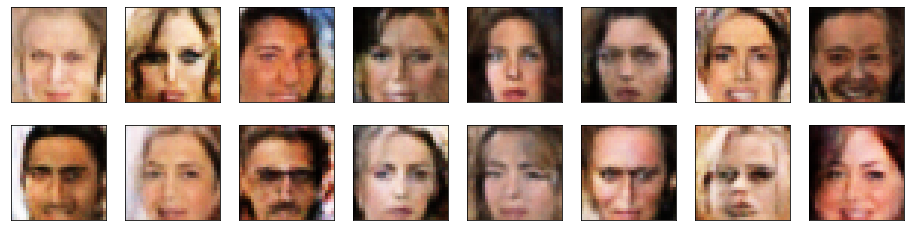

Epoch [    2/  101] | d_loss: 1.0684 | g_loss: 2.6802
Epoch [    2/  101] | d_loss: 0.9944 | g_loss: 1.6166
Epoch [    2/  101] | d_loss: 0.7768 | g_loss: 2.2820
Epoch [    2/  101] | d_loss: 1.0510 | g_loss: 1.1299
Epoch [    2/  101] | d_loss: 0.9274 | g_loss: 2.2818
Epoch [    2/  101] | d_loss: 0.4928 | g_loss: 1.8888
Epoch [    2/  101] | d_loss: 0.9772 | g_loss: 1.3467
Epoch [    2/  101] | d_loss: 0.8153 | g_loss: 0.9070
Epoch [    2/  101] | d_loss: 1.0142 | g_loss: 2.2518
Epoch [    2/  101] | d_loss: 1.3784 | g_loss: 0.7770
Epoch [    2/  101] | d_loss: 0.6770 | g_loss: 1.3562
Epoch [    2/  101] | d_loss: 0.9335 | g_loss: 1.1383
Epoch [    2/  101] | d_loss: 0.8810 | g_loss: 1.2444
Epoch [    2/  101] | d_loss: 1.0816 | g_loss: 0.7844
Epoch [    2/  101] | d_loss: 1.1568 | g_loss: 2.6318
Epoch [    2/  101] | d_loss: 1.2624 | g_loss: 2.8423
Epoch [    2/  101] | d_loss: 0.8185 | g_loss: 1.7306
Epoch [    2/  101] | d_loss: 0.7535 | g_loss: 1.9607
Epoch [    2/  101] | d_loss

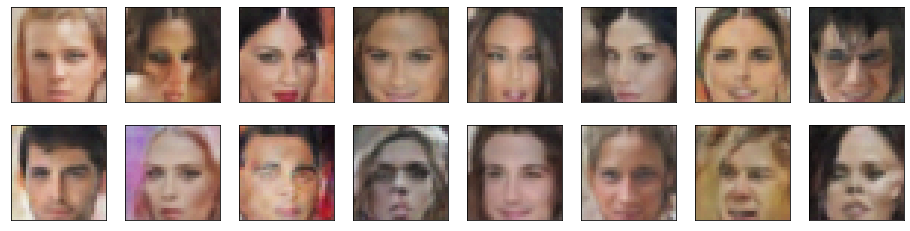

Epoch [   12/  101] | d_loss: 0.0664 | g_loss: 4.2888
Epoch [   12/  101] | d_loss: 0.3857 | g_loss: 4.7196
Epoch [   12/  101] | d_loss: 0.4809 | g_loss: 1.4608
Epoch [   12/  101] | d_loss: 0.0600 | g_loss: 4.9396
Epoch [   12/  101] | d_loss: 0.6482 | g_loss: 5.8637
Epoch [   12/  101] | d_loss: 0.2032 | g_loss: 4.3229
Epoch [   12/  101] | d_loss: 0.2907 | g_loss: 3.0977
Epoch [   12/  101] | d_loss: 0.1980 | g_loss: 4.2526
Epoch [   12/  101] | d_loss: 0.2020 | g_loss: 4.6050
Epoch [   12/  101] | d_loss: 3.4808 | g_loss: 7.4349
Epoch [   12/  101] | d_loss: 0.1378 | g_loss: 2.9890
Epoch [   12/  101] | d_loss: 0.0706 | g_loss: 3.7011
Epoch [   12/  101] | d_loss: 0.2771 | g_loss: 3.7481
Epoch [   12/  101] | d_loss: 0.2001 | g_loss: 5.1044
Epoch [   12/  101] | d_loss: 0.1650 | g_loss: 6.3058
Epoch [   12/  101] | d_loss: 0.3555 | g_loss: 3.6068
Epoch [   12/  101] | d_loss: 0.2674 | g_loss: 5.3222
Epoch [   12/  101] | d_loss: 0.2381 | g_loss: 2.9240
Epoch [   12/  101] | d_loss

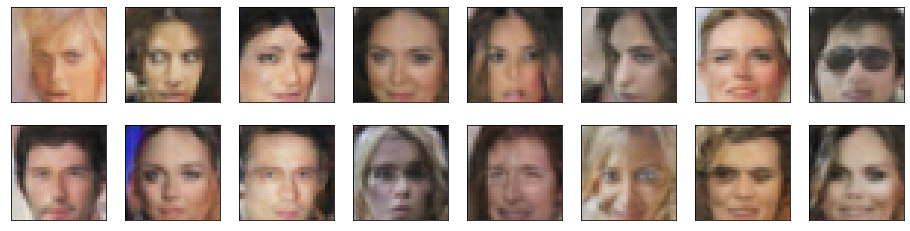

Epoch [   22/  101] | d_loss: 0.0195 | g_loss: 4.4080
Epoch [   22/  101] | d_loss: 0.2891 | g_loss: 4.1039
Epoch [   22/  101] | d_loss: 0.0286 | g_loss: 4.3205
Epoch [   22/  101] | d_loss: 0.0421 | g_loss: 5.8559
Epoch [   22/  101] | d_loss: 0.1287 | g_loss: 5.8853
Epoch [   22/  101] | d_loss: 0.5744 | g_loss: 2.0735
Epoch [   22/  101] | d_loss: 0.3268 | g_loss: 2.4636
Epoch [   22/  101] | d_loss: 0.0383 | g_loss: 4.5409
Epoch [   22/  101] | d_loss: 0.0381 | g_loss: 5.8325
Epoch [   22/  101] | d_loss: 0.0520 | g_loss: 5.0420
Epoch [   22/  101] | d_loss: 0.2463 | g_loss: 3.3868
Epoch [   22/  101] | d_loss: 0.2779 | g_loss: 5.8482
Epoch [   22/  101] | d_loss: 0.0121 | g_loss: 4.9816
Epoch [   22/  101] | d_loss: 0.2330 | g_loss: 2.7045
Epoch [   22/  101] | d_loss: 0.0752 | g_loss: 5.0980
Epoch [   22/  101] | d_loss: 0.1512 | g_loss: 3.7096
Epoch [   22/  101] | d_loss: 0.0801 | g_loss: 5.9678
Epoch [   22/  101] | d_loss: 0.0077 | g_loss: 5.5167
Epoch [   22/  101] | d_loss

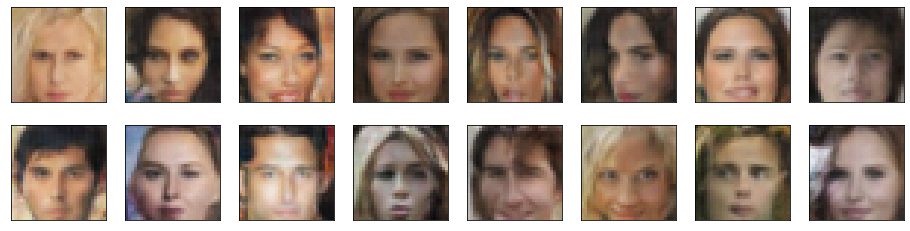

Epoch [   32/  101] | d_loss: 0.2080 | g_loss: 3.9430
Epoch [   32/  101] | d_loss: 0.0277 | g_loss: 7.0663
Epoch [   32/  101] | d_loss: 0.3398 | g_loss: 4.9879
Epoch [   32/  101] | d_loss: 0.1986 | g_loss: 3.7712
Epoch [   32/  101] | d_loss: 0.0421 | g_loss: 6.8846
Epoch [   32/  101] | d_loss: 0.0767 | g_loss: 5.6614
Epoch [   32/  101] | d_loss: 0.1374 | g_loss: 7.1091
Epoch [   32/  101] | d_loss: 0.0484 | g_loss: 3.9546
Epoch [   32/  101] | d_loss: 0.0688 | g_loss: 6.0662
Epoch [   32/  101] | d_loss: 0.1537 | g_loss: 4.7652
Epoch [   32/  101] | d_loss: 0.0120 | g_loss: 5.5918
Epoch [   32/  101] | d_loss: 0.0147 | g_loss: 6.2130
Epoch [   32/  101] | d_loss: 0.0261 | g_loss: 4.4895
Epoch [   32/  101] | d_loss: 0.1718 | g_loss: 5.9734
Epoch [   32/  101] | d_loss: 0.0465 | g_loss: 7.3684
Epoch [   32/  101] | d_loss: 0.0323 | g_loss: 5.3111
Epoch [   32/  101] | d_loss: 0.0153 | g_loss: 5.5652
Epoch [   32/  101] | d_loss: 0.4113 | g_loss: 5.1363
Epoch [   32/  101] | d_loss

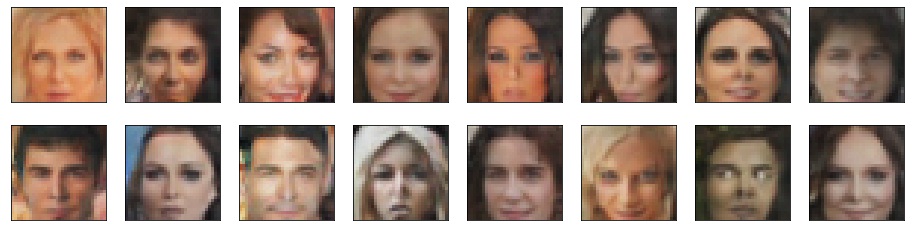

Epoch [   42/  101] | d_loss: 0.0145 | g_loss: 7.2233
Epoch [   42/  101] | d_loss: 0.1750 | g_loss: 2.4769
Epoch [   42/  101] | d_loss: 0.0321 | g_loss: 6.1095
Epoch [   42/  101] | d_loss: 0.1364 | g_loss: 5.1452
Epoch [   42/  101] | d_loss: 0.0499 | g_loss: 5.4612
Epoch [   42/  101] | d_loss: 0.0290 | g_loss: 6.9041
Epoch [   42/  101] | d_loss: 0.6311 | g_loss: 0.3749
Epoch [   42/  101] | d_loss: 0.0503 | g_loss: 5.8475
Epoch [   42/  101] | d_loss: 0.0404 | g_loss: 5.0725
Epoch [   42/  101] | d_loss: 0.0183 | g_loss: 7.0838
Epoch [   42/  101] | d_loss: 0.0058 | g_loss: 6.7619
Epoch [   42/  101] | d_loss: 0.1529 | g_loss: 4.1097
Epoch [   42/  101] | d_loss: 0.1573 | g_loss: 6.8601
Epoch [   42/  101] | d_loss: 0.0103 | g_loss: 5.2478
Epoch [   42/  101] | d_loss: 0.0654 | g_loss: 6.1121
Epoch [   42/  101] | d_loss: 0.0220 | g_loss: 6.0575
Epoch [   42/  101] | d_loss: 0.0112 | g_loss: 7.1655
Epoch [   42/  101] | d_loss: 0.1403 | g_loss: 3.7635
Epoch [   42/  101] | d_loss

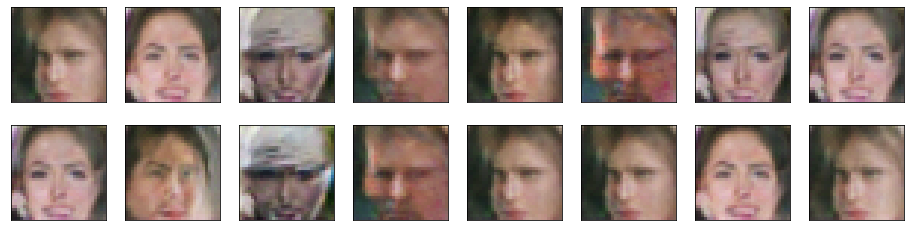

Epoch [   52/  101] | d_loss: 2.9491 | g_loss: 30.5711
Epoch [   52/  101] | d_loss: 0.0132 | g_loss: 5.8949
Epoch [   52/  101] | d_loss: 0.0341 | g_loss: 5.9597
Epoch [   52/  101] | d_loss: 0.0053 | g_loss: 4.4382
Epoch [   52/  101] | d_loss: 0.0099 | g_loss: 5.9324
Epoch [   52/  101] | d_loss: 0.0195 | g_loss: 4.6536
Epoch [   52/  101] | d_loss: 0.0536 | g_loss: 8.5390
Epoch [   52/  101] | d_loss: 0.1819 | g_loss: 6.2039
Epoch [   52/  101] | d_loss: 0.0203 | g_loss: 3.9576
Epoch [   52/  101] | d_loss: 0.0803 | g_loss: 9.2022
Epoch [   52/  101] | d_loss: 0.3329 | g_loss: 14.8318
Epoch [   52/  101] | d_loss: 0.0125 | g_loss: 7.9559
Epoch [   52/  101] | d_loss: 0.0537 | g_loss: 6.1910
Epoch [   52/  101] | d_loss: 0.0264 | g_loss: 4.7048
Epoch [   52/  101] | d_loss: 0.0659 | g_loss: 5.1394
Epoch [   52/  101] | d_loss: 0.0004 | g_loss: 9.5180
Epoch [   52/  101] | d_loss: 0.0251 | g_loss: 3.8025
Epoch [   52/  101] | d_loss: 0.0129 | g_loss: 9.9988
Epoch [   52/  101] | d_lo

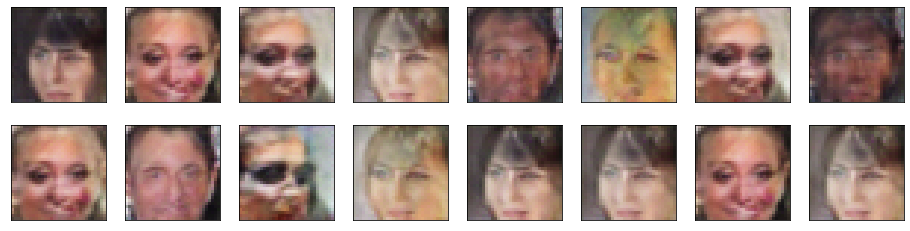

Epoch [   62/  101] | d_loss: 2.3586 | g_loss: 26.0393
Epoch [   62/  101] | d_loss: 0.0035 | g_loss: 7.6315
Epoch [   62/  101] | d_loss: 0.0014 | g_loss: 8.6470
Epoch [   62/  101] | d_loss: 0.0630 | g_loss: 10.0651
Epoch [   62/  101] | d_loss: 0.0140 | g_loss: 6.1118
Epoch [   62/  101] | d_loss: 0.0345 | g_loss: 5.3455
Epoch [   62/  101] | d_loss: 0.0816 | g_loss: 7.4816
Epoch [   62/  101] | d_loss: 0.0778 | g_loss: 4.5555
Epoch [   62/  101] | d_loss: 0.0083 | g_loss: 7.2130
Epoch [   62/  101] | d_loss: 0.0108 | g_loss: 6.0662
Epoch [   62/  101] | d_loss: 0.0087 | g_loss: 6.1801
Epoch [   62/  101] | d_loss: 0.0079 | g_loss: 5.9918
Epoch [   62/  101] | d_loss: 0.0038 | g_loss: 8.1127
Epoch [   62/  101] | d_loss: 0.0094 | g_loss: 7.3644
Epoch [   62/  101] | d_loss: 0.2195 | g_loss: 11.8270
Epoch [   62/  101] | d_loss: 0.0123 | g_loss: 7.4530
Epoch [   62/  101] | d_loss: 0.0008 | g_loss: 5.3225
Epoch [   62/  101] | d_loss: 0.0224 | g_loss: 3.2285
Epoch [   62/  101] | d_l

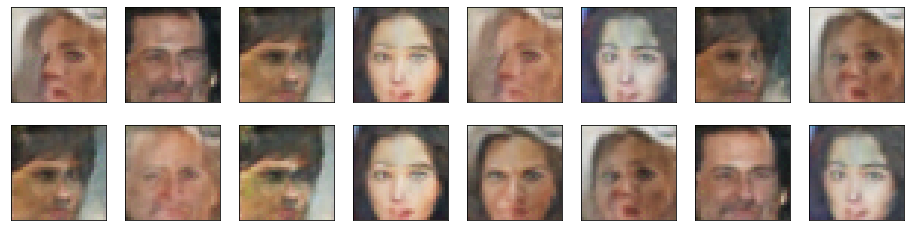

Epoch [   72/  101] | d_loss: 7.5284 | g_loss: 29.1067
Epoch [   72/  101] | d_loss: 0.1286 | g_loss: 5.9387
Epoch [   72/  101] | d_loss: 0.0005 | g_loss: 8.3791
Epoch [   72/  101] | d_loss: 0.0256 | g_loss: 14.5714
Epoch [   72/  101] | d_loss: 0.0080 | g_loss: 8.7606
Epoch [   72/  101] | d_loss: 0.0103 | g_loss: 12.9302
Epoch [   72/  101] | d_loss: 0.0509 | g_loss: 6.6551
Epoch [   72/  101] | d_loss: 0.1088 | g_loss: 11.6460
Epoch [   72/  101] | d_loss: 0.0006 | g_loss: 11.7979
Epoch [   72/  101] | d_loss: 0.0252 | g_loss: 5.1105
Epoch [   72/  101] | d_loss: 0.0069 | g_loss: 6.6815
Epoch [   72/  101] | d_loss: 0.0814 | g_loss: 5.9180
Epoch [   72/  101] | d_loss: 0.0004 | g_loss: 12.2768
Epoch [   72/  101] | d_loss: 0.0161 | g_loss: 9.3466
Epoch [   72/  101] | d_loss: 0.0078 | g_loss: 13.5447
Epoch [   72/  101] | d_loss: 0.0859 | g_loss: 4.7664
Epoch [   72/  101] | d_loss: 0.0309 | g_loss: 5.9027
Epoch [   72/  101] | d_loss: 0.0015 | g_loss: 6.9700
Epoch [   72/  101] |

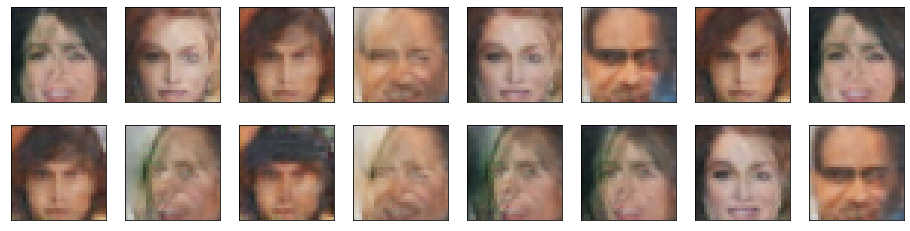

Epoch [   82/  101] | d_loss: 0.1629 | g_loss: 12.9830
Epoch [   82/  101] | d_loss: 0.0286 | g_loss: 7.9443
Epoch [   82/  101] | d_loss: 0.0001 | g_loss: 10.8787
Epoch [   82/  101] | d_loss: 0.0136 | g_loss: 6.3342
Epoch [   82/  101] | d_loss: 0.0087 | g_loss: 8.0764
Epoch [   82/  101] | d_loss: 0.0055 | g_loss: 4.0000
Epoch [   82/  101] | d_loss: 0.0166 | g_loss: 7.1046
Epoch [   82/  101] | d_loss: 0.0039 | g_loss: 13.3160
Epoch [   82/  101] | d_loss: 0.0012 | g_loss: 9.6500
Epoch [   82/  101] | d_loss: 0.0013 | g_loss: 15.3044
Epoch [   82/  101] | d_loss: 0.0209 | g_loss: 7.3625
Epoch [   82/  101] | d_loss: 0.0019 | g_loss: 5.2610
Epoch [   82/  101] | d_loss: 0.0316 | g_loss: 6.6139
Epoch [   82/  101] | d_loss: 0.0043 | g_loss: 6.1726
Epoch [   82/  101] | d_loss: 0.0005 | g_loss: 6.9037
Epoch [   82/  101] | d_loss: 0.0193 | g_loss: 10.2870
Epoch [   82/  101] | d_loss: 0.0041 | g_loss: 9.0306
Epoch [   82/  101] | d_loss: 0.0049 | g_loss: 10.1046
Epoch [   82/  101] | 

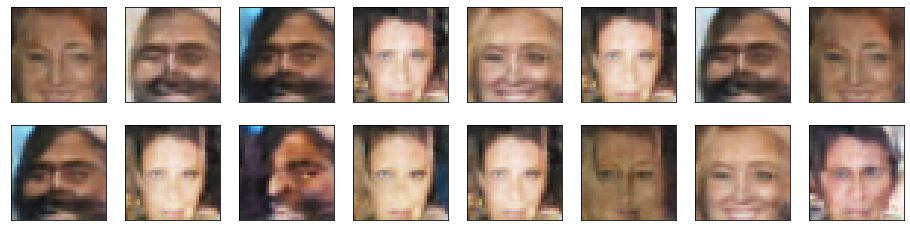

Epoch [   92/  101] | d_loss: 0.1942 | g_loss: 14.2782
Epoch [   92/  101] | d_loss: 0.0009 | g_loss: 6.6166
Epoch [   92/  101] | d_loss: 0.0013 | g_loss: 11.6286
Epoch [   92/  101] | d_loss: 0.0023 | g_loss: 10.6851
Epoch [   92/  101] | d_loss: 0.0006 | g_loss: 8.6484
Epoch [   92/  101] | d_loss: 0.0003 | g_loss: 7.5733
Epoch [   92/  101] | d_loss: 0.0066 | g_loss: 7.6631
Epoch [   92/  101] | d_loss: 0.0124 | g_loss: 15.5484
Epoch [   92/  101] | d_loss: 0.0052 | g_loss: 9.3324
Epoch [   92/  101] | d_loss: 0.0052 | g_loss: 7.9352
Epoch [   92/  101] | d_loss: 0.0058 | g_loss: 18.4206
Epoch [   92/  101] | d_loss: 0.1626 | g_loss: 8.8690
Epoch [   92/  101] | d_loss: 0.0016 | g_loss: 7.4673
Epoch [   92/  101] | d_loss: 0.0092 | g_loss: 7.8536
Epoch [   92/  101] | d_loss: 9.1020 | g_loss: 25.6382
Epoch [   92/  101] | d_loss: 0.0000 | g_loss: 12.1563
Epoch [   92/  101] | d_loss: 0.0122 | g_loss: 4.5101
Epoch [   92/  101] | d_loss: 0.0020 | g_loss: 9.8897
Epoch [   92/  101] |

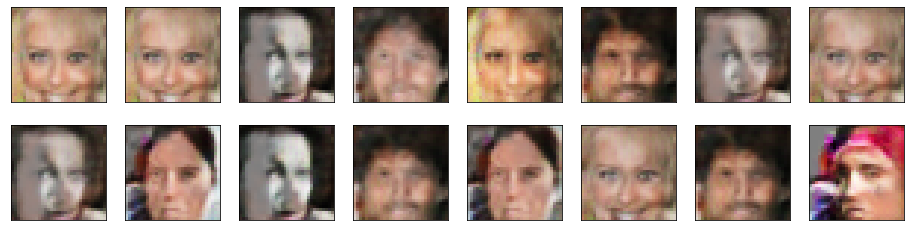

{'batch_size': 32, 'img_size': 32, 'deconv-layers': 3, 'conv-layers': 3, 'd_conv_dim': 64, 'g_conv_dim': 64, 'z_size': 100, 'lr': 0.0002, 'beta1': 0.2, 'beta2': 0.999, 'dropout': 'no', 'n_epochs': 101}
Plot Loss


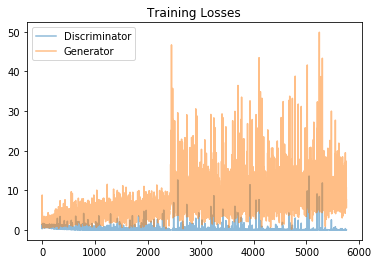

In [37]:
# tune hyperparameters by calling the training function in a loop
n_epochs=101
#for index, n_epochs in enumerate(number_epochs):
#for index, conv_dim in enumerate(conv_dim_set):
#for index, lr in enumerate(lr_set):
for index, batch_size in enumerate(batch_size_set):
    # Set Parameter
    n_epochs = n_epochs
    lr = lr
    batch_size = batch_size
    d_conv_dim = conv_dim
    g_conv_dim = conv_dim
    
    # Get dataloader
    celeba_train_loader = get_dataloader(batch_size, img_size)
    
    # Build network
    print('Build Network')
    D, G = build_network(d_conv_dim, g_conv_dim, z_size)
    
    # Reset optimizer
    d_optimizer, g_optimizer = optimizer(lr)
    
    # Calculate losses
    losses = train(D, G, n_epochs=n_epochs, index=index)
    
    # Save and Plot Data
    save_data(index, losses, batch_size)
    plot_training_loss(losses)
    #_ = view_samples(index, epoch=-1)
    

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

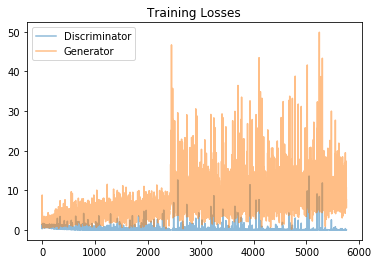

In [38]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [1]:
# helper function for viewing a list of passed in sample images
def view_samples_2(epoch, samples, train_num, param_value):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    fig.suptitle(param_value)
    fig.savefig('image_sets/train_' + str(train_num) + '_' + str(param_value) + '.png')

In [2]:
# helper function for viewing a list of passed in sample images
def view_plots(train_runs, title, param):
    number_of_pots = len(train_runs)
    train_run_list = [m[0] for m in train_runs]
    param_list = [m[1] for m in train_runs]
    epochs_calc = [m[2] for m in train_runs]
    
    ax_set = ('a' + str(m) for m in range(number_of_pots))
    
    fig, ax_set = plt.subplots(figsize=(16,4), nrows=1, ncols=number_of_pots)
    fig.suptitle(title)
    for ii,train_num in enumerate(train_run_list):
        df = pd.read_excel('training_results/train_' + str(train_num) + '_' + str(param_list[ii]) + '.xlsx')  
        loss_d = df['Discriminator'].values
        loss_g = df['Generator'].values
        ax_set[ii].plot(df.index/epochs_calc[ii], loss_d, label='Discriminator')
        ax_set[ii].plot(df.index/epochs_calc[ii], loss_g, label='Generator')
        ax_set[ii].set_title('Train_' + str(train_num))
        #ax_set[ii].xlabel('n_epochs', fontsize=14)
        #ax_set[iniidex].ylabel('loss', fontsize=14)
        ax_set[ii].legend()
        

In the following section the parameter tuning investigated in separated training runs is depicted. Furthermore the resulting **Loss** for each training run (parameter variation) is shown as a measure of training success.

<a id='Parameter_n_epochs'></a>

## Parameter: n_epochs

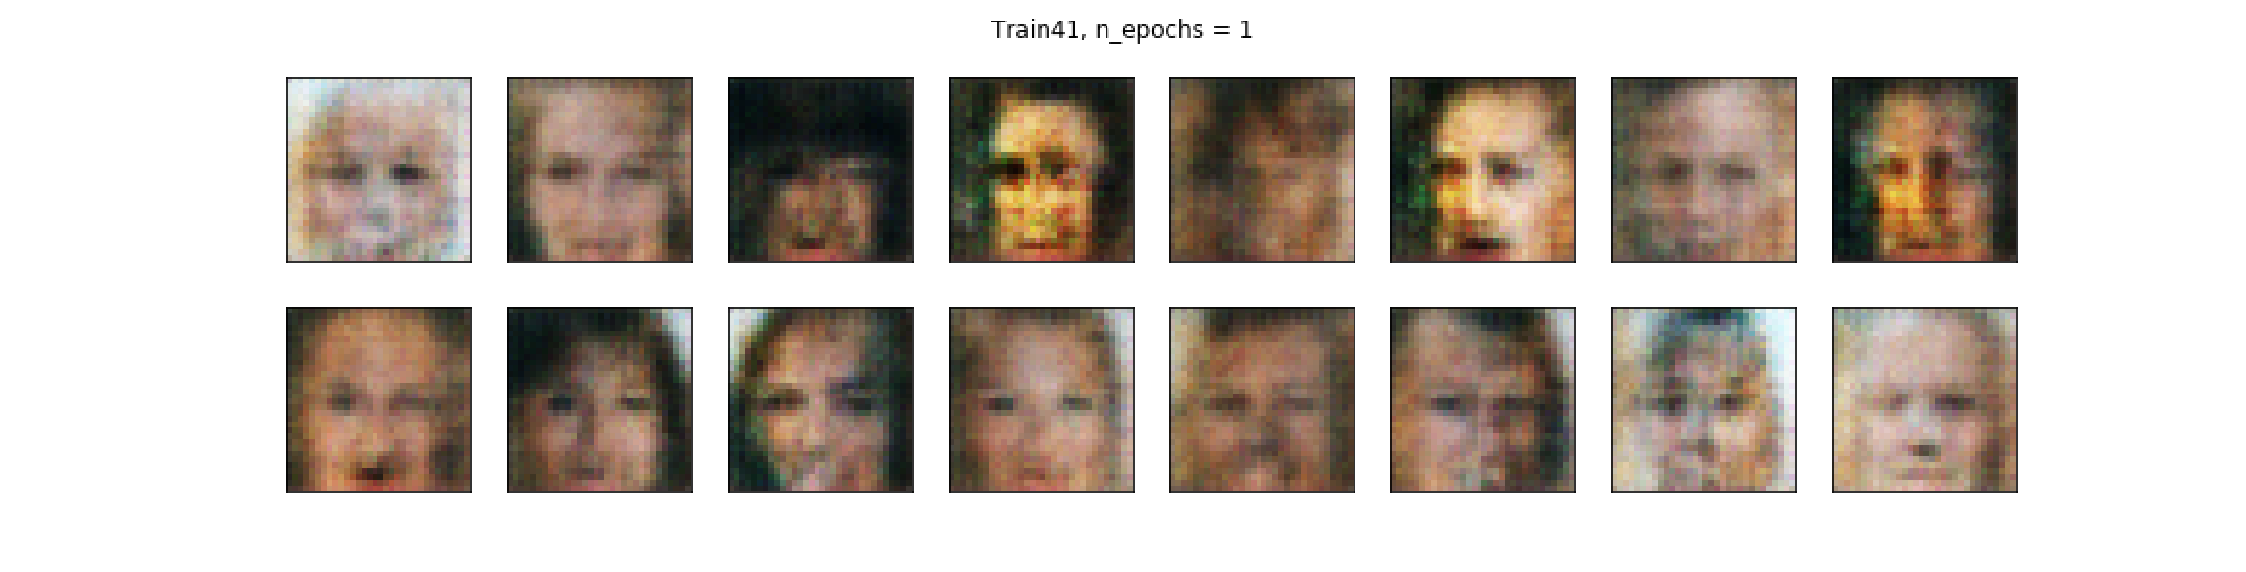

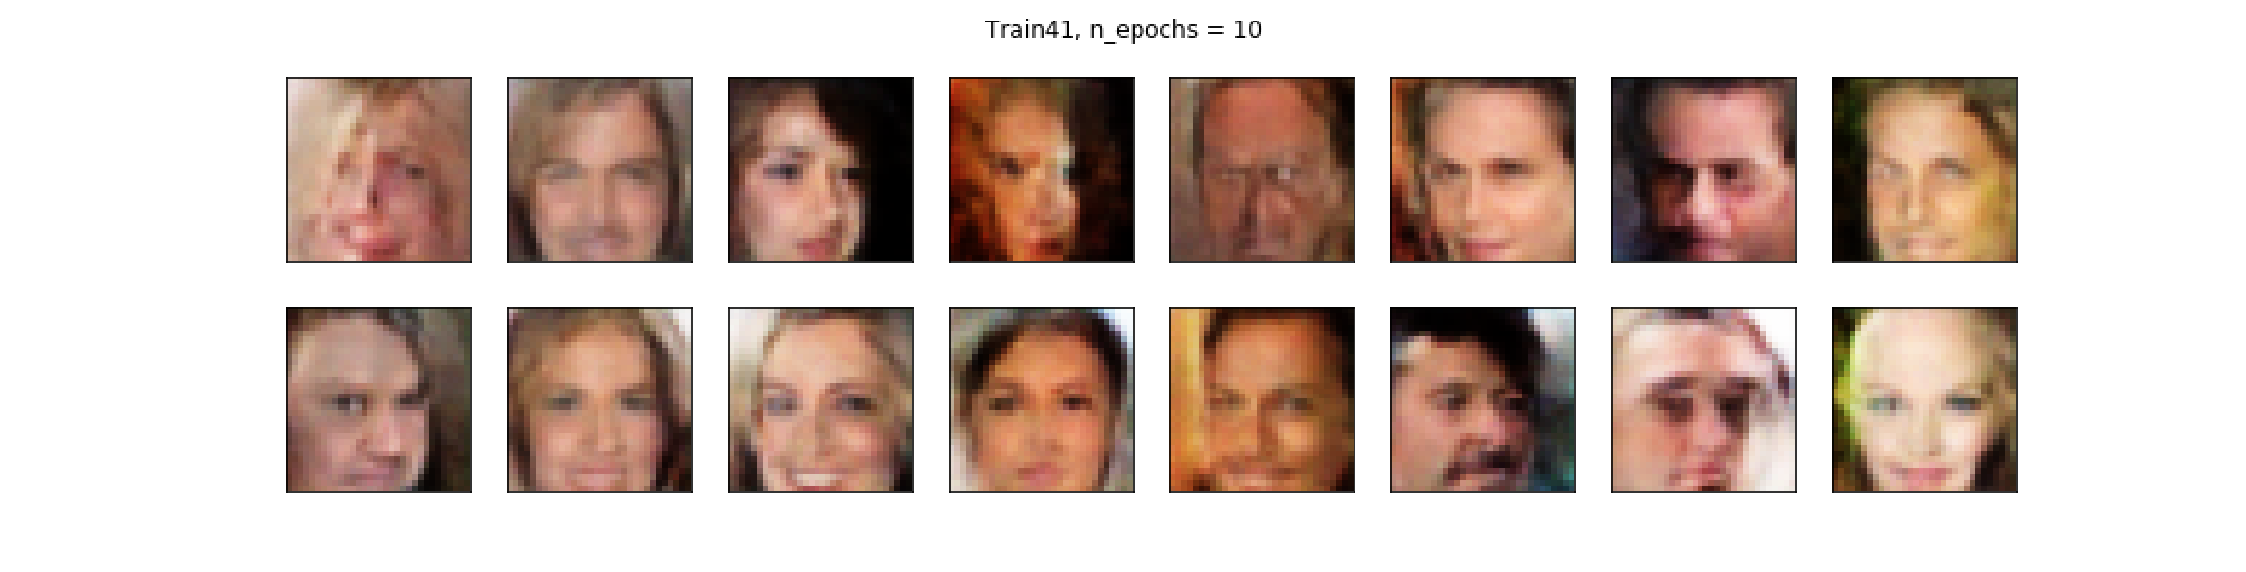

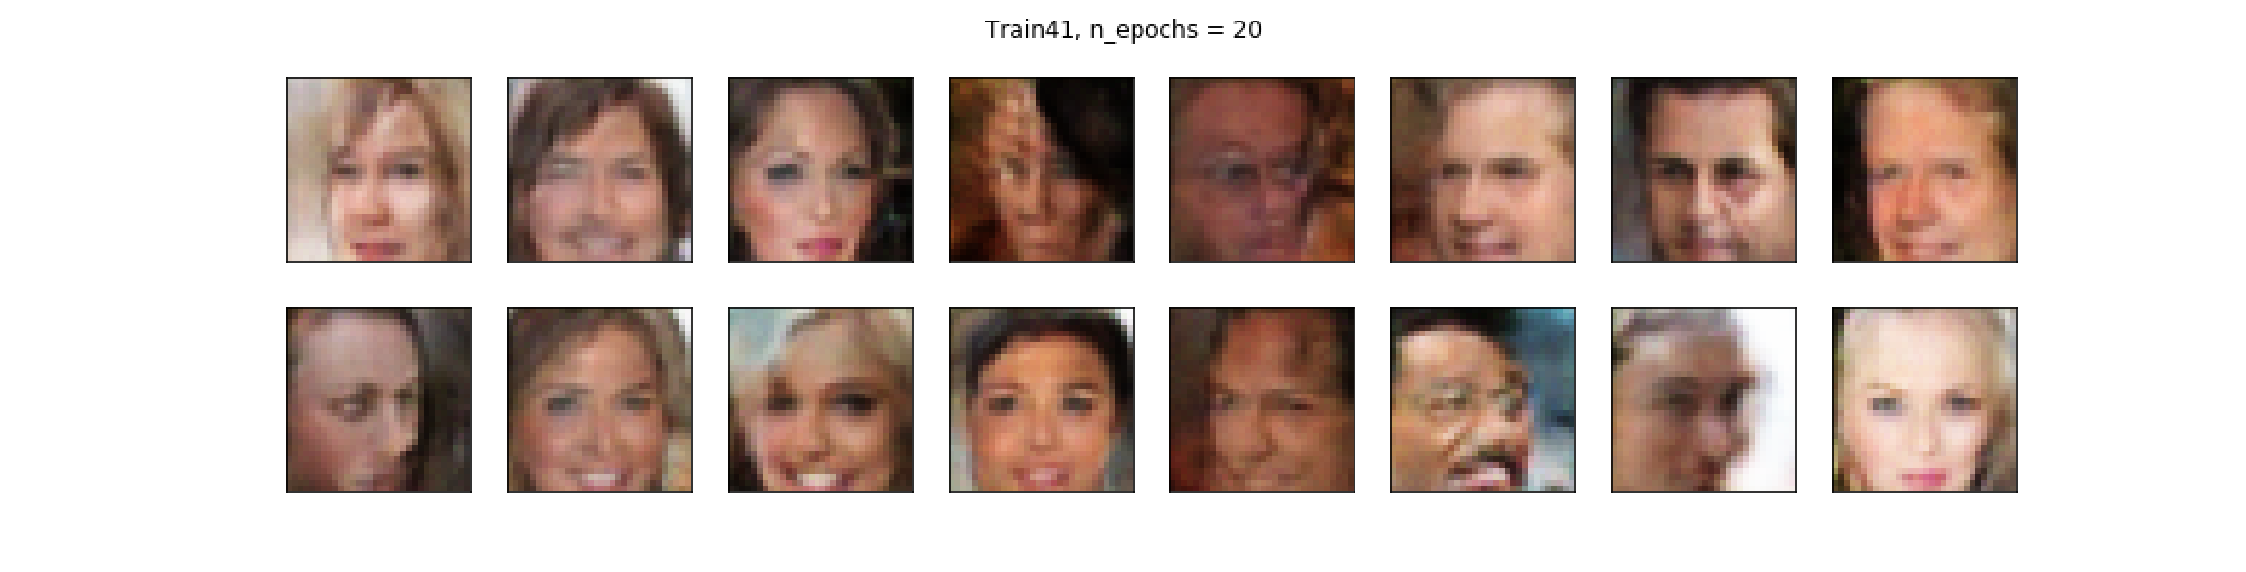

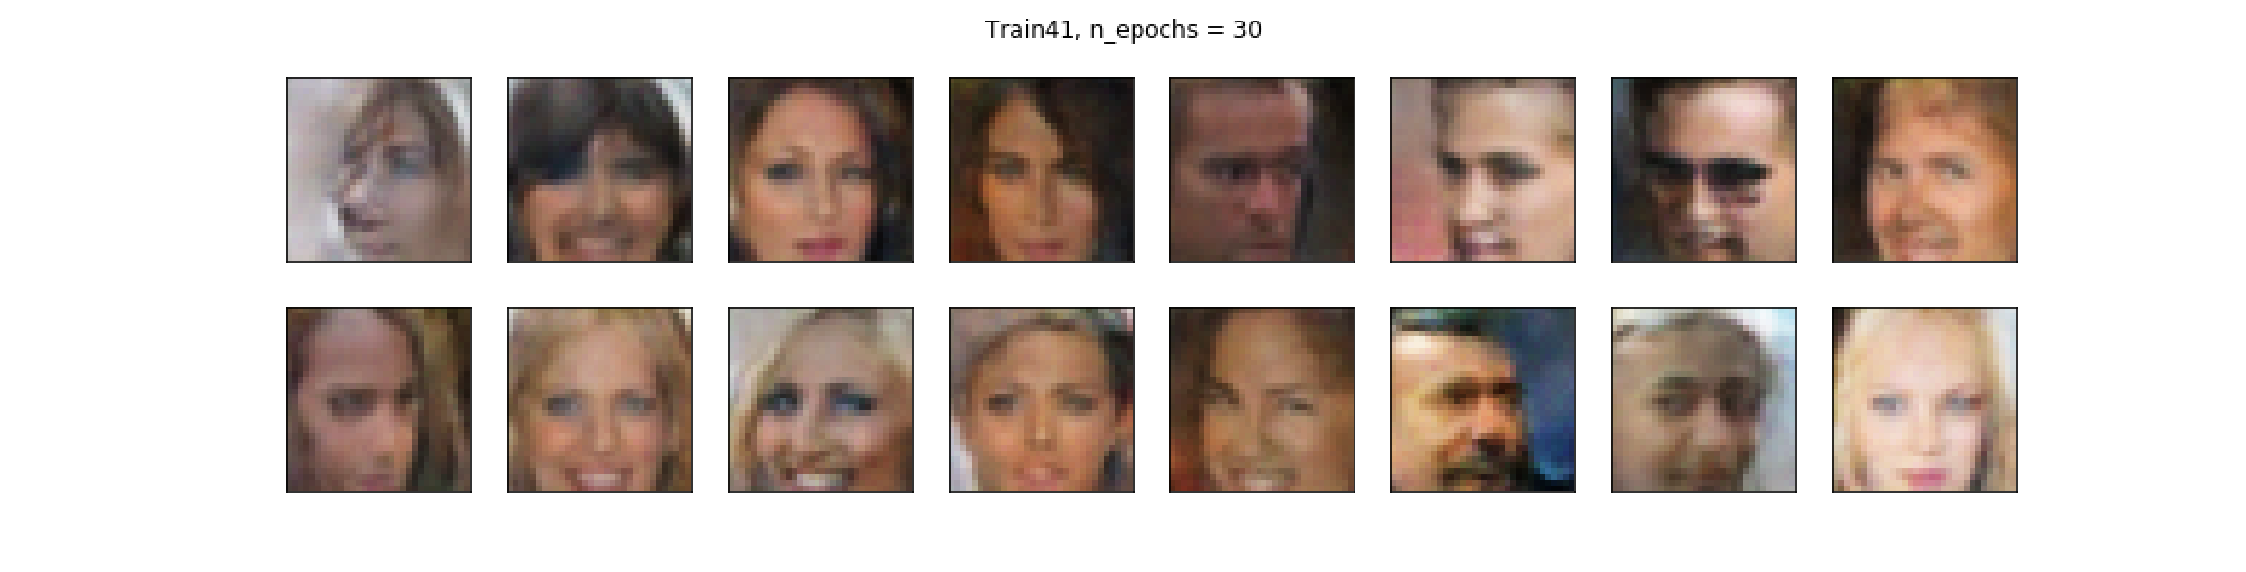

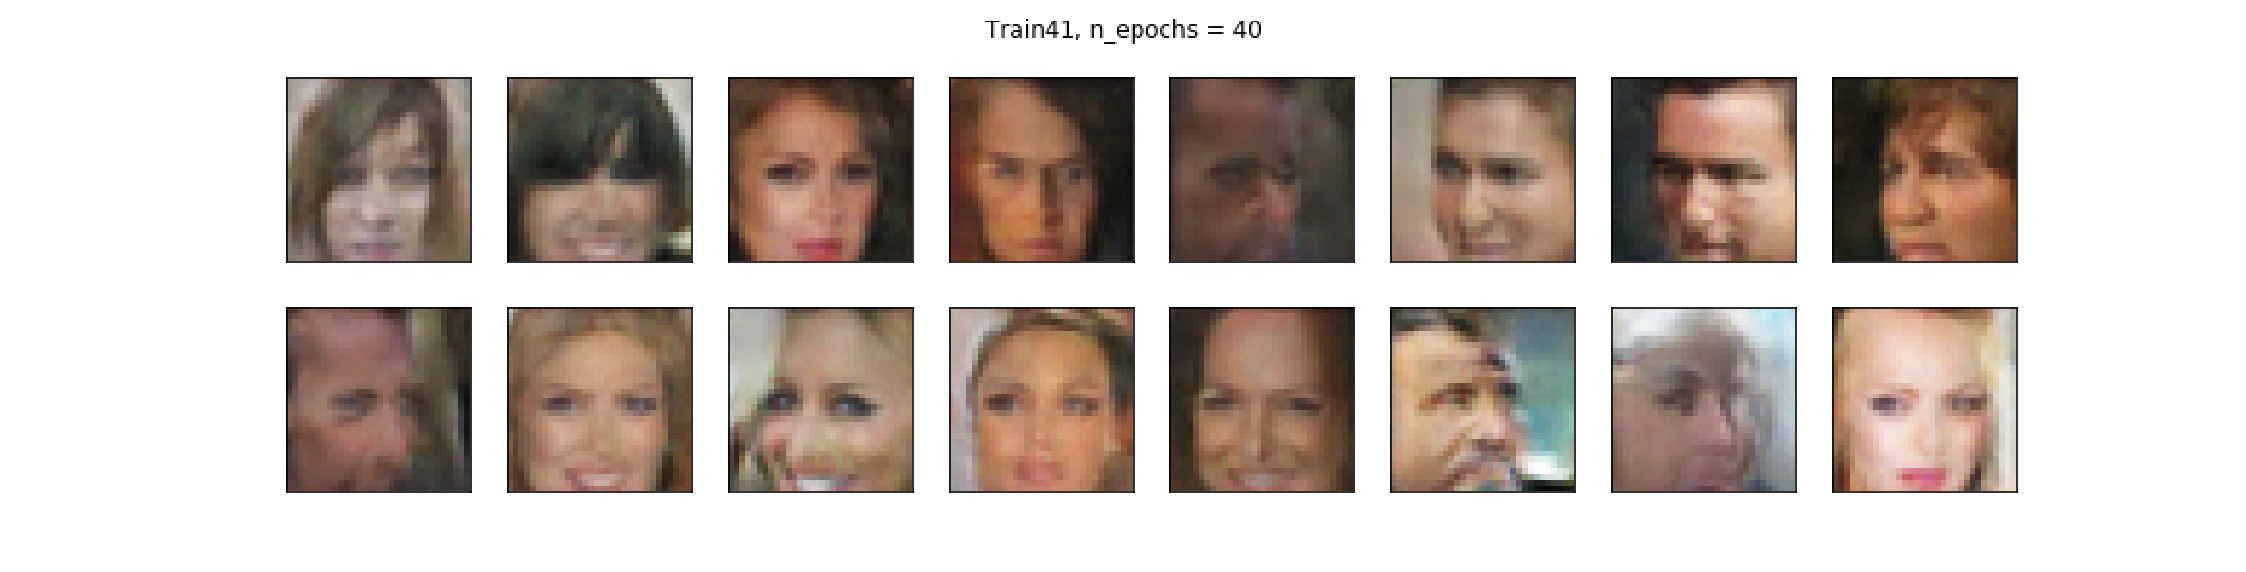

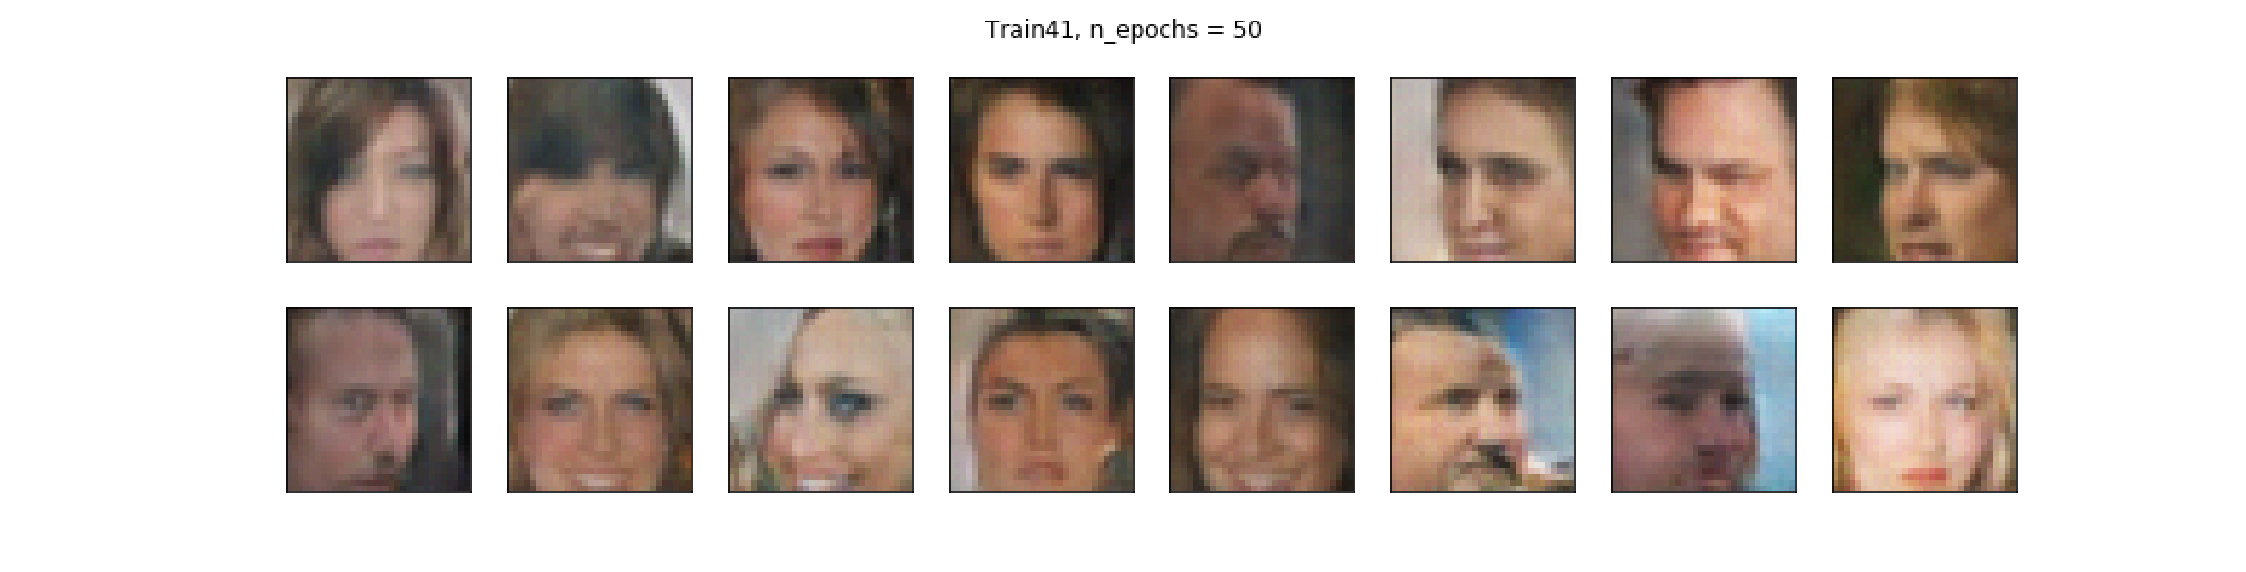

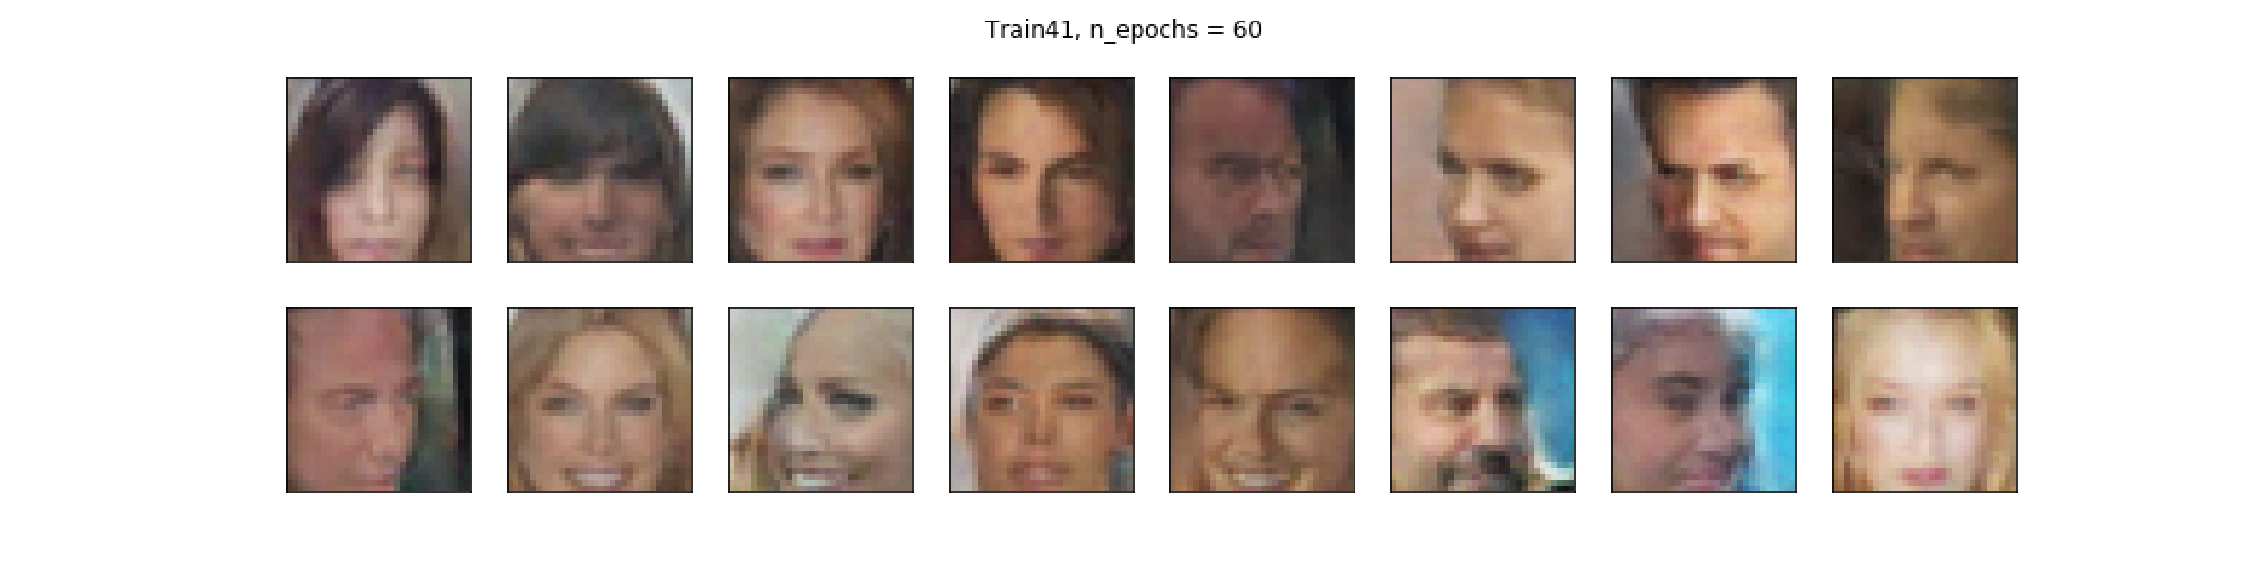

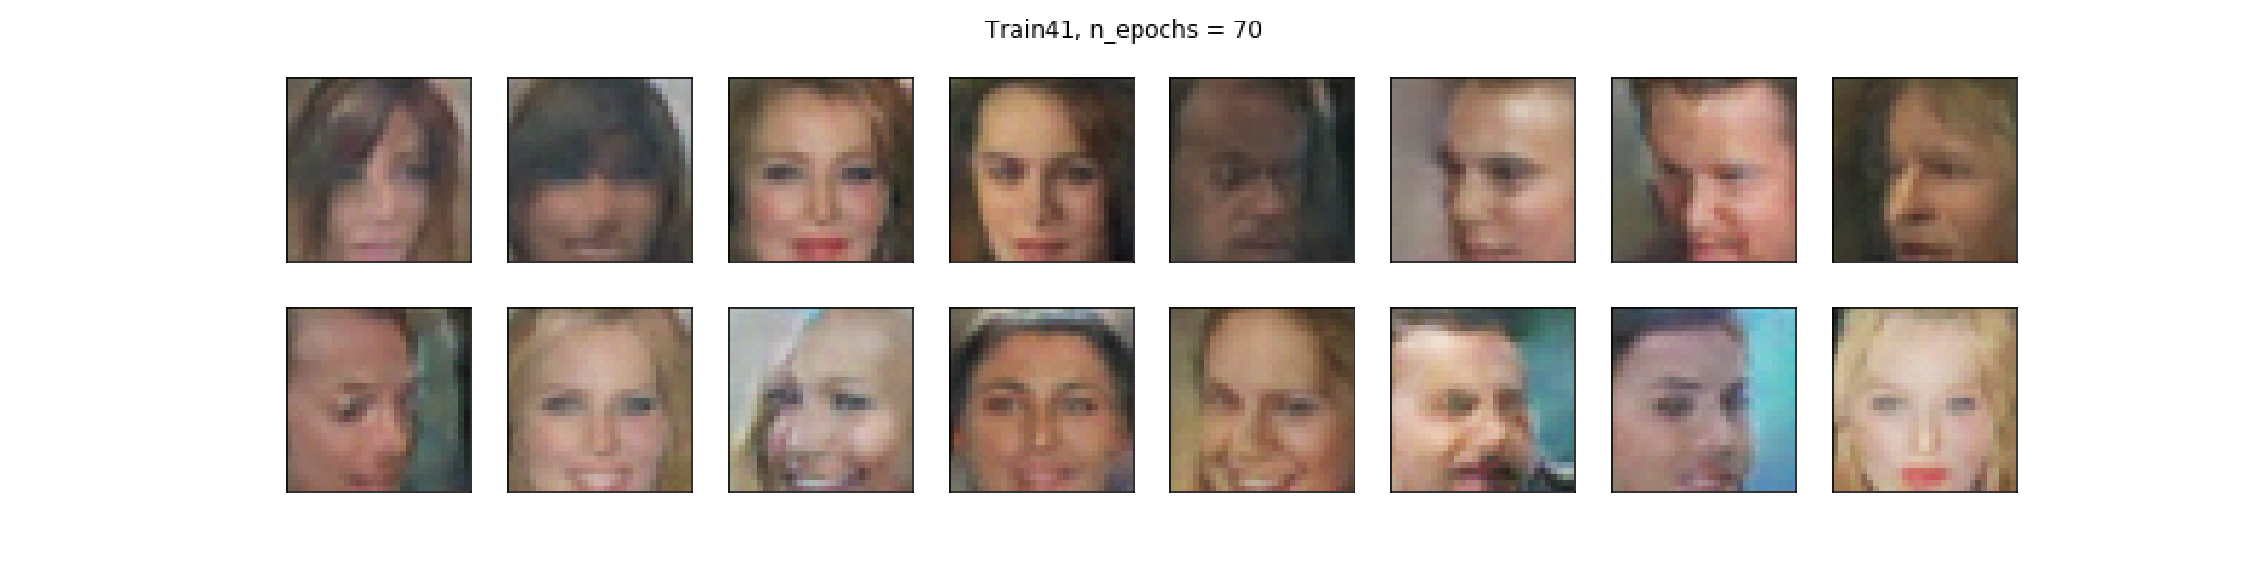

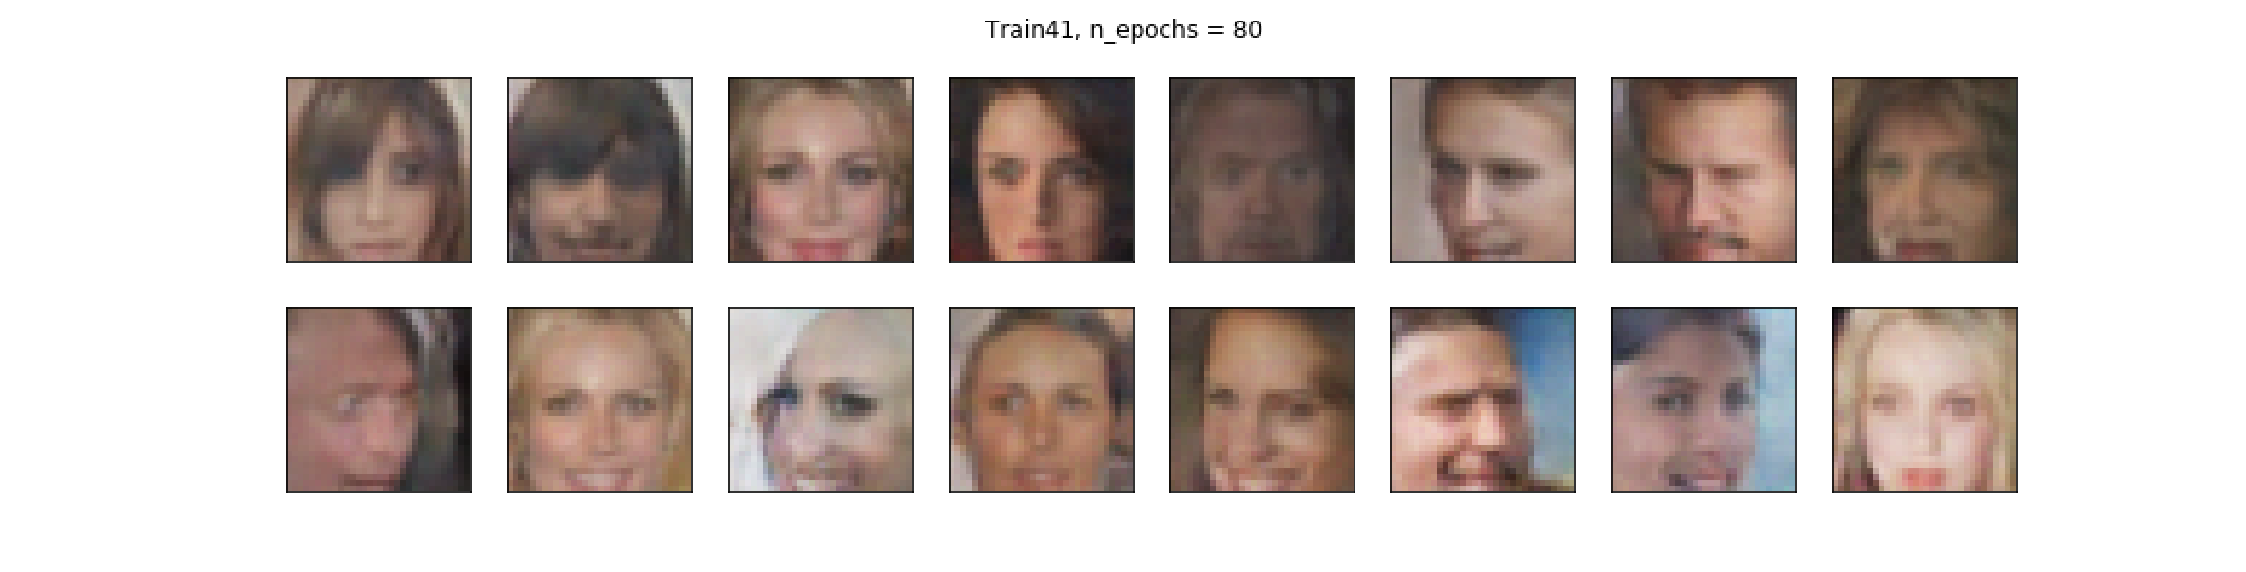

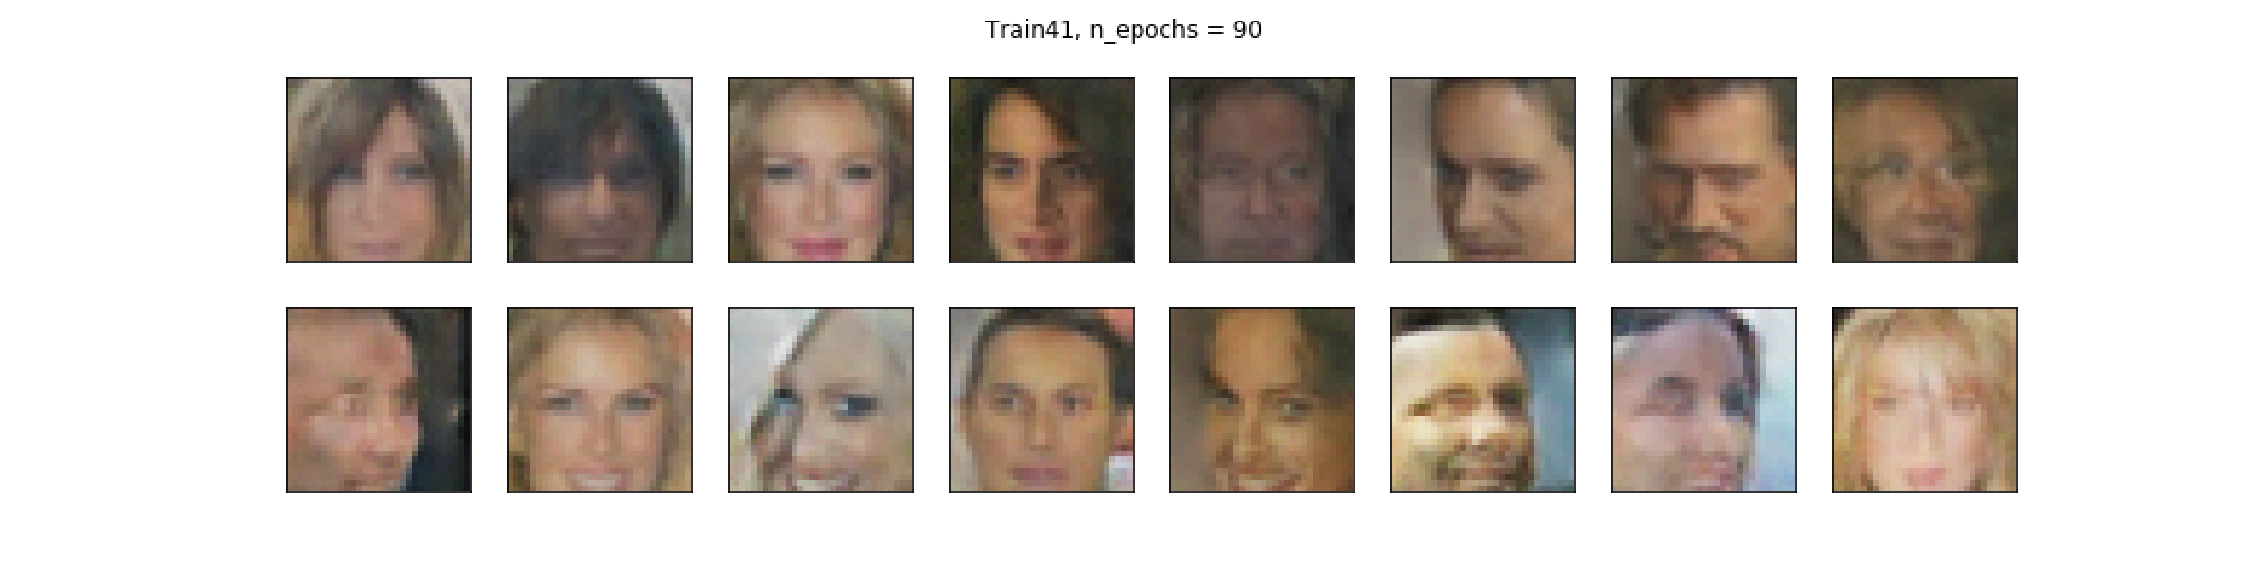

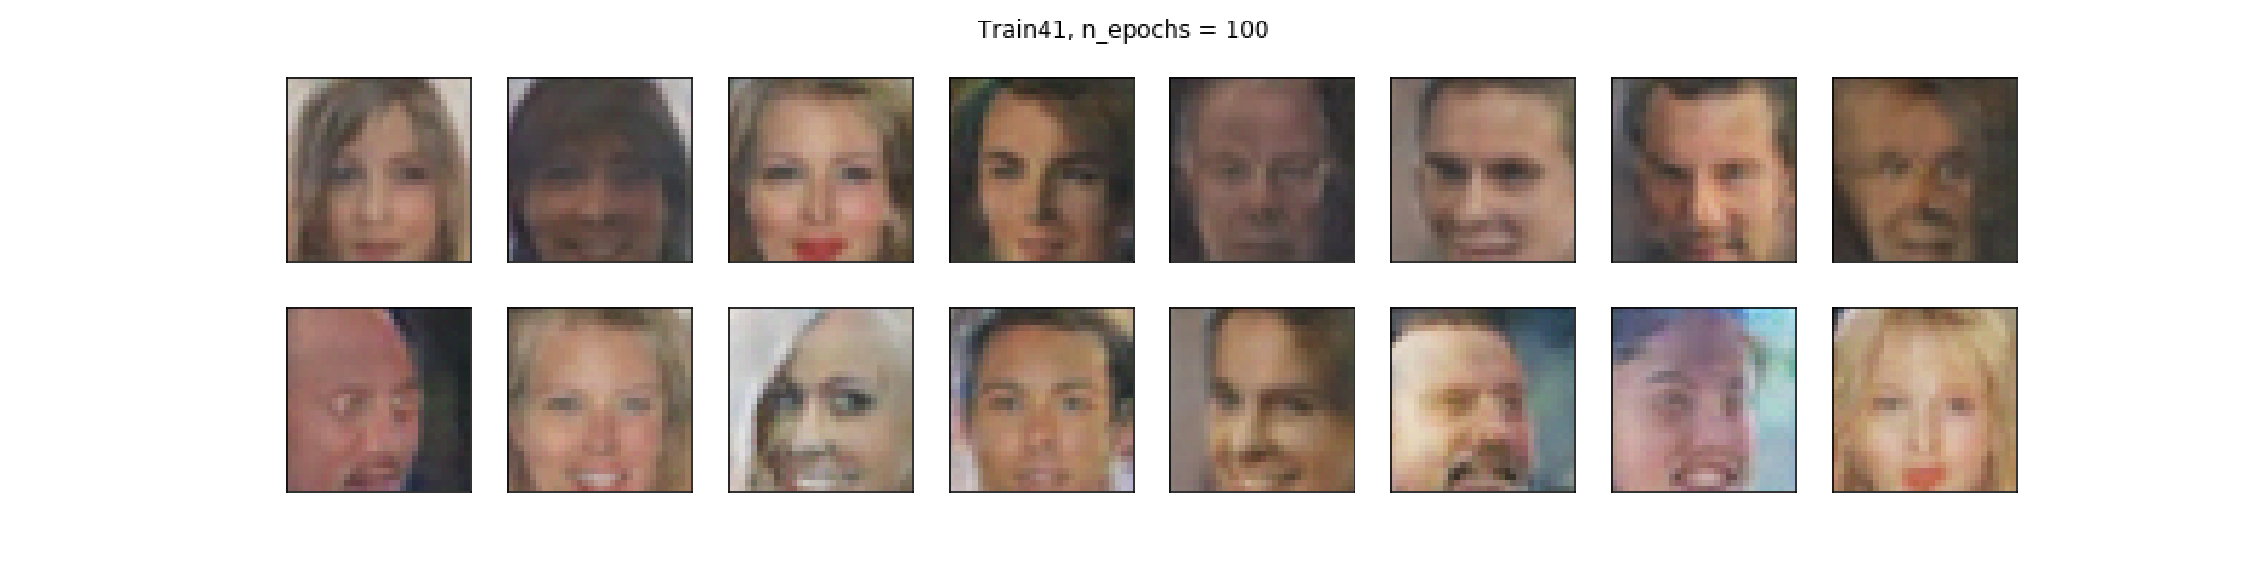

In [71]:
# n_epochs = 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100
parameter_list_name = ['Train41, n_epochs = 1', 'Train41, n_epochs = 10', 'Train41, n_epochs = 20', 'Train41, n_epochs = 30', 'Train41, n_epochs = 40', 'Train41, n_epochs = 50', 'Train41, n_epochs = 60', 'Train41, n_epochs = 70', 'Train41, n_epochs = 80', 'Train41, n_epochs = 90', 'Train41, n_epochs = 100']
train_num_list = [41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41]
param_list = ['drop', 'drop', 'drop', 'drop', 'drop', 'drop', 'drop', 'drop', 'drop', 'drop', 'drop']
epoch_list = [0, 10, 20, 30 , 40, 50, 60, 70, 80, 90 ,100]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

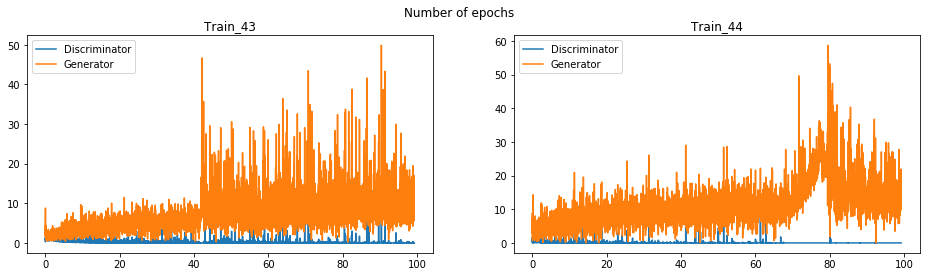

In [27]:
view_plots([[43, 'drop', 58],[44, 'drop', 58]], 'Number of epochs', 'n_epochs') 

### Result for parameter n_epochs:
Best value setting for the number of epochs extends to the range 20...70. Lower epoch values lead to underfitting, higher epoch values tend to pronounced noisy behavior of the discriminator loss. In both regimes the generated face images are blurred. 

<a id='Parameter_number_conv_deconv_layers'></a>

## Parameter: number of conv-layers and deconv-layers
One model with number of conv-layers=deconv_layers=3 was compared to another model with number of conv-layers=deconv_layers=4. For simplification of the model pictures below, ReLU activation and batch normalization layers were neglected. 

<img src='assets/number_conv_deconv_layers.png' width=60% />

Parameters          | 4th Train-Run | 8th Train-Run | 
----------          | ------------- | ------------- |
batch_size          |   128         |   128         |  
img_size            |   32          |   32          | 
**deconv-layers**   |   `3`         |   `4`         |
**conv-layers**     |   `3`         |   `4`         | 
d_conv_dim          |   32          |   32          |
g_conv_dim          |   32          |   32          | 
z_size              |   100         |   100         |  
lr                  |   0.001       |   0.001       |  
beta1               |   0.5         |   0.5         | 
beta2               |   0.999       |   0.999       |
dropout             |   no          |   no          |
n_epochs            |   100         |   100         |

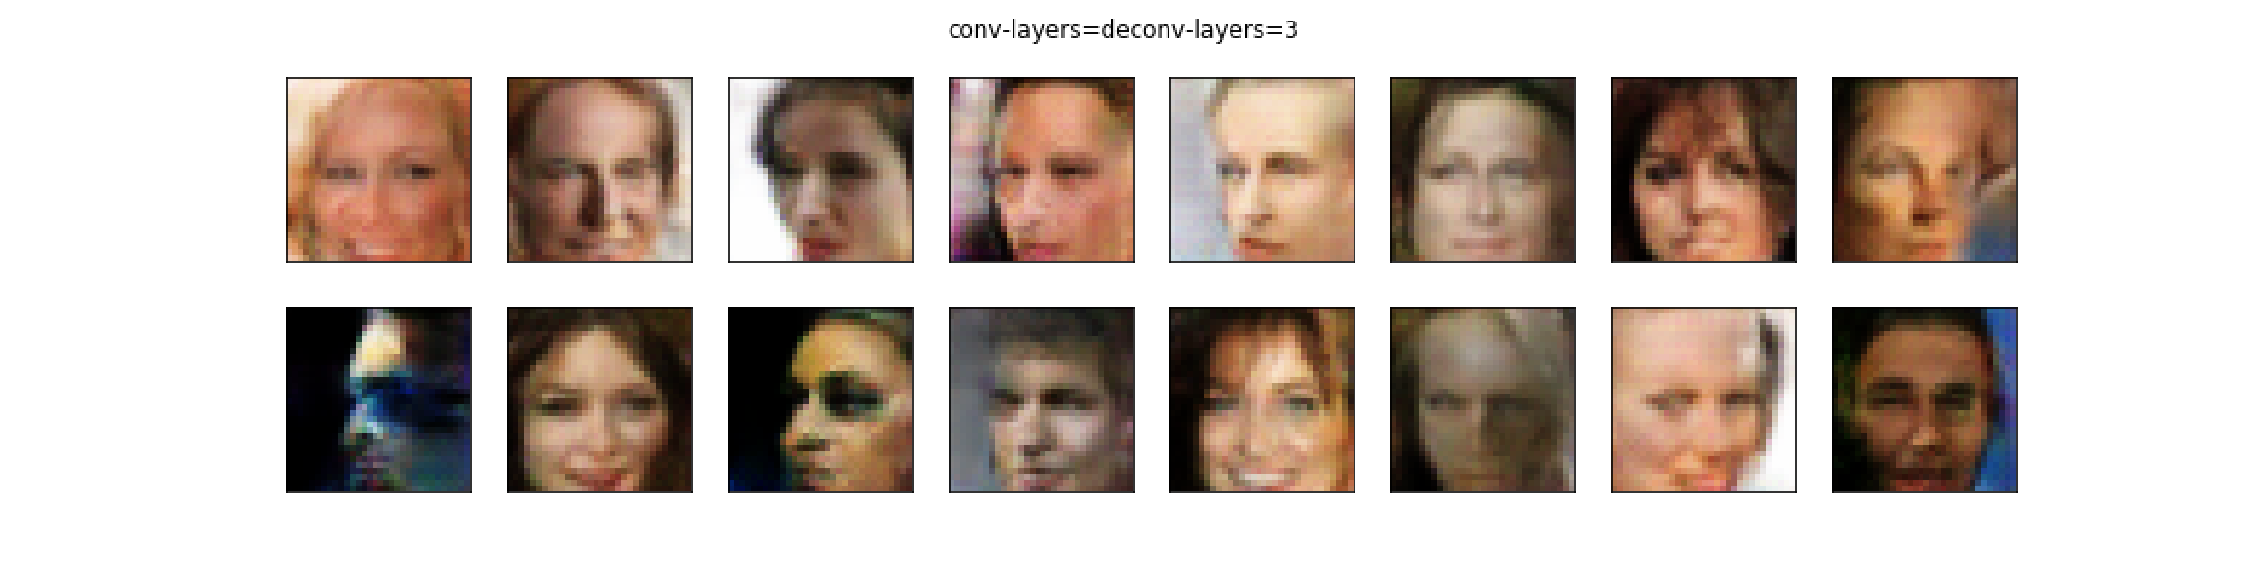

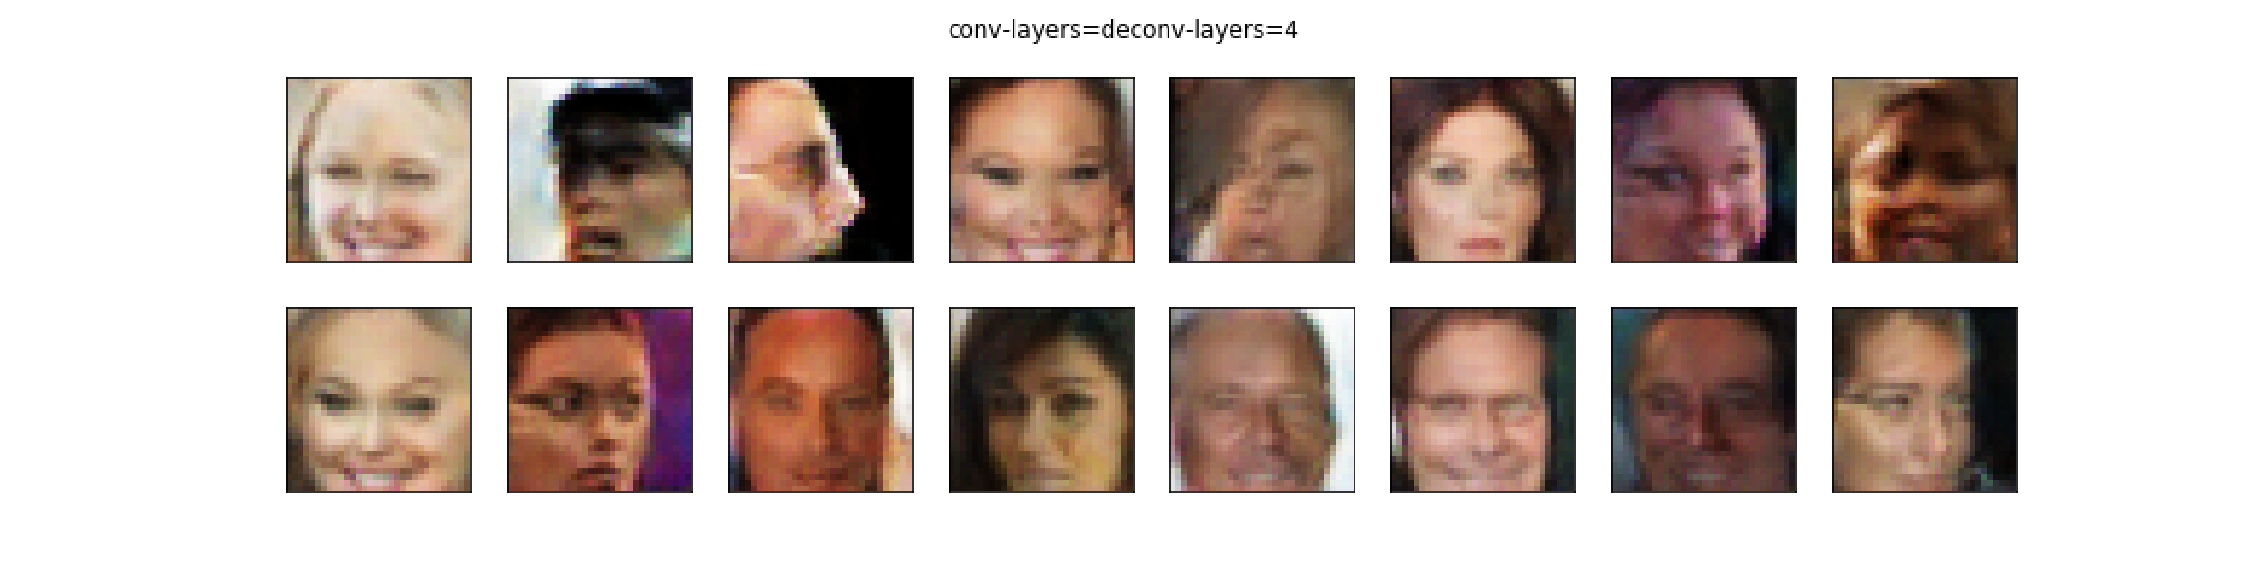

In [40]:
# conv-layers=deconv-layers=3 ... 4
parameter_list_name = ['conv-layers=deconv-layers=3','conv-layers=deconv-layers=4']
train_num_list = [4, 8]
param_list = ['num_epochs', 'conv_deconv']
epoch_list = [100, 100]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

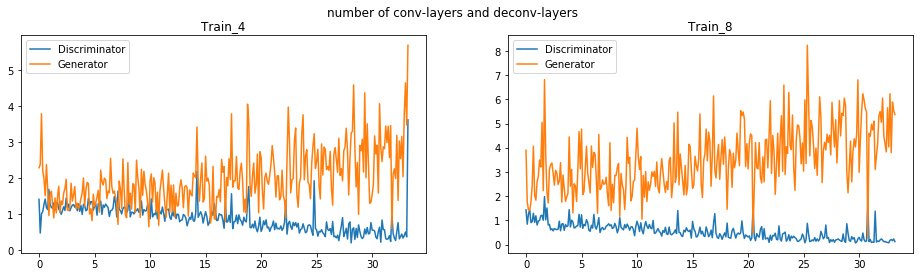

In [41]:
view_plots([[4, 'num_epochs', 9],
            [8, 'conv_deconv', 9]],'number of conv-layers and deconv-layers', 'conv_deconv')  

### Result for parameter number of conv-layers and deconv-layers:
There is no clear trend with regard to the number of conv-layers and deconv-layers. Corresponding images for conv-layers=3 and deconv-layers=3 look similar to conv-layers=4 and deconv-layers=4. However, the trend of losses is slightly better for conv-layers=4 and deconv-layers=4, higher (positive) loss for the Generator and slightly lower loss for the Discriminator. In the following conv-layers=4 and deconv-layers=4 will be used for further parameter studies.

<a id='Parameter_conv_dim'></a>

## Parameter: conv_dim

Parameters          | 8th Train-Run | 11th Train-Run  | 12th Train-Run  | 13th Train-Run |
----------          | ------------- | -------------   | -------------   | -------------  |
batch_size          |   128         |   128           |   128           |  128           |   
img_size            |   32          |   32            |   32            |   32           |
deconv-layers       |   4           |   4             |   4             |   4            |
conv-layers         |   4           |   4             |   4             |   4            |
**d_conv_dim**      |   `32`        |   `64`          |   `128`         |  `256`         |   
**g_conv_dim**      |   `32`        |   `64`          |   `128`         |  `256`         |
z_size              |   100         |   100           |   100           |   100          |   
lr                  |   0.001       |   0.001         |   0.001         |   0.001        |  
beta1               |   0.5         |   0.5           |   0.5           |   0.5          |
beta2               |   0.999       |   0.999         |   0.999         |   0.999        |
dropout             |   no          |   no            |   no            |   no           |
n_epochs            |   100         |   100           |   100           |   100          |

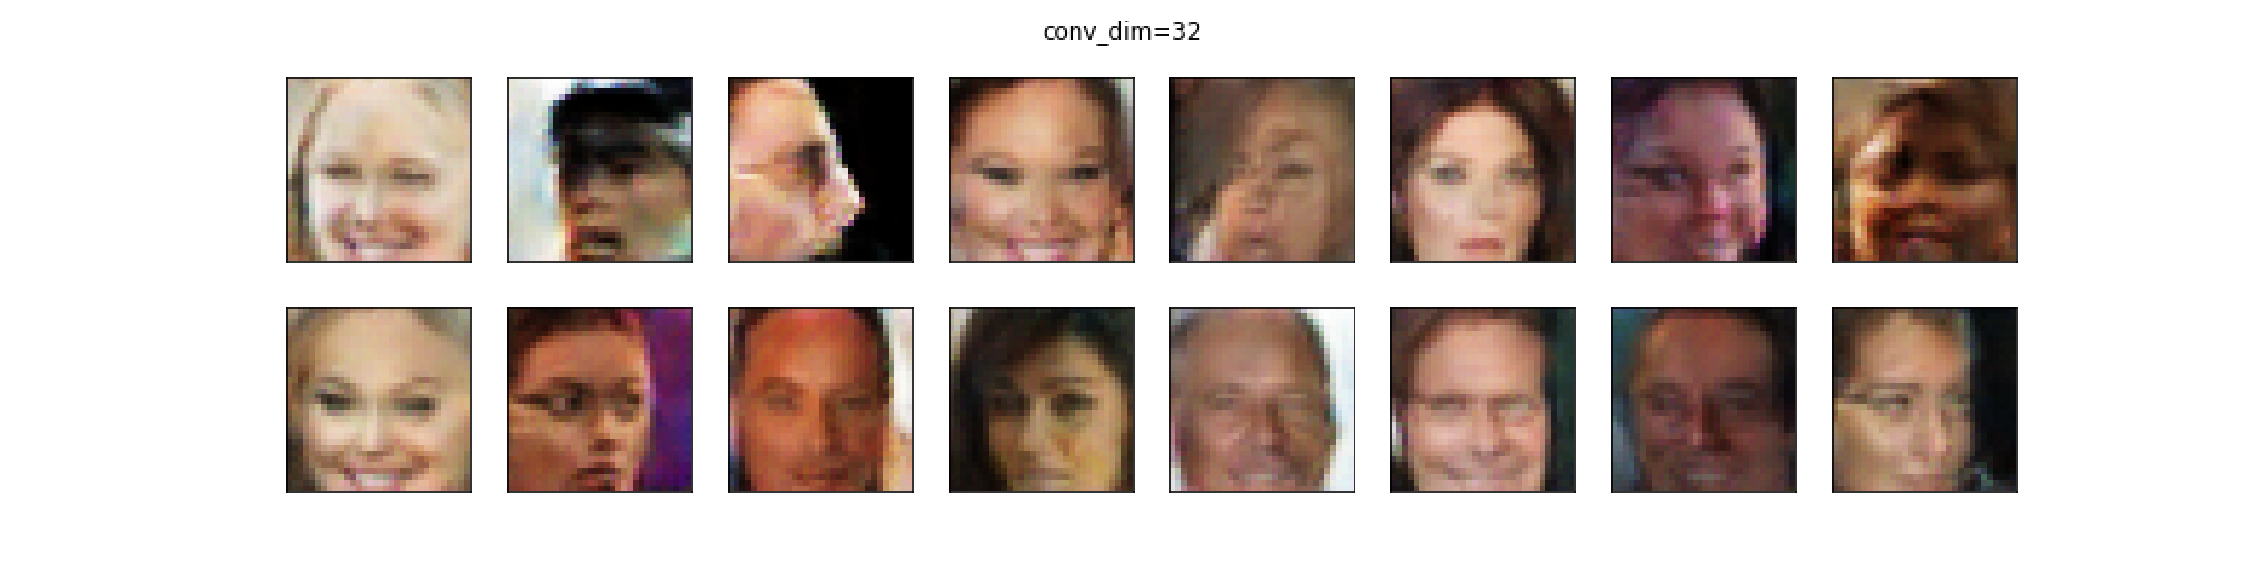

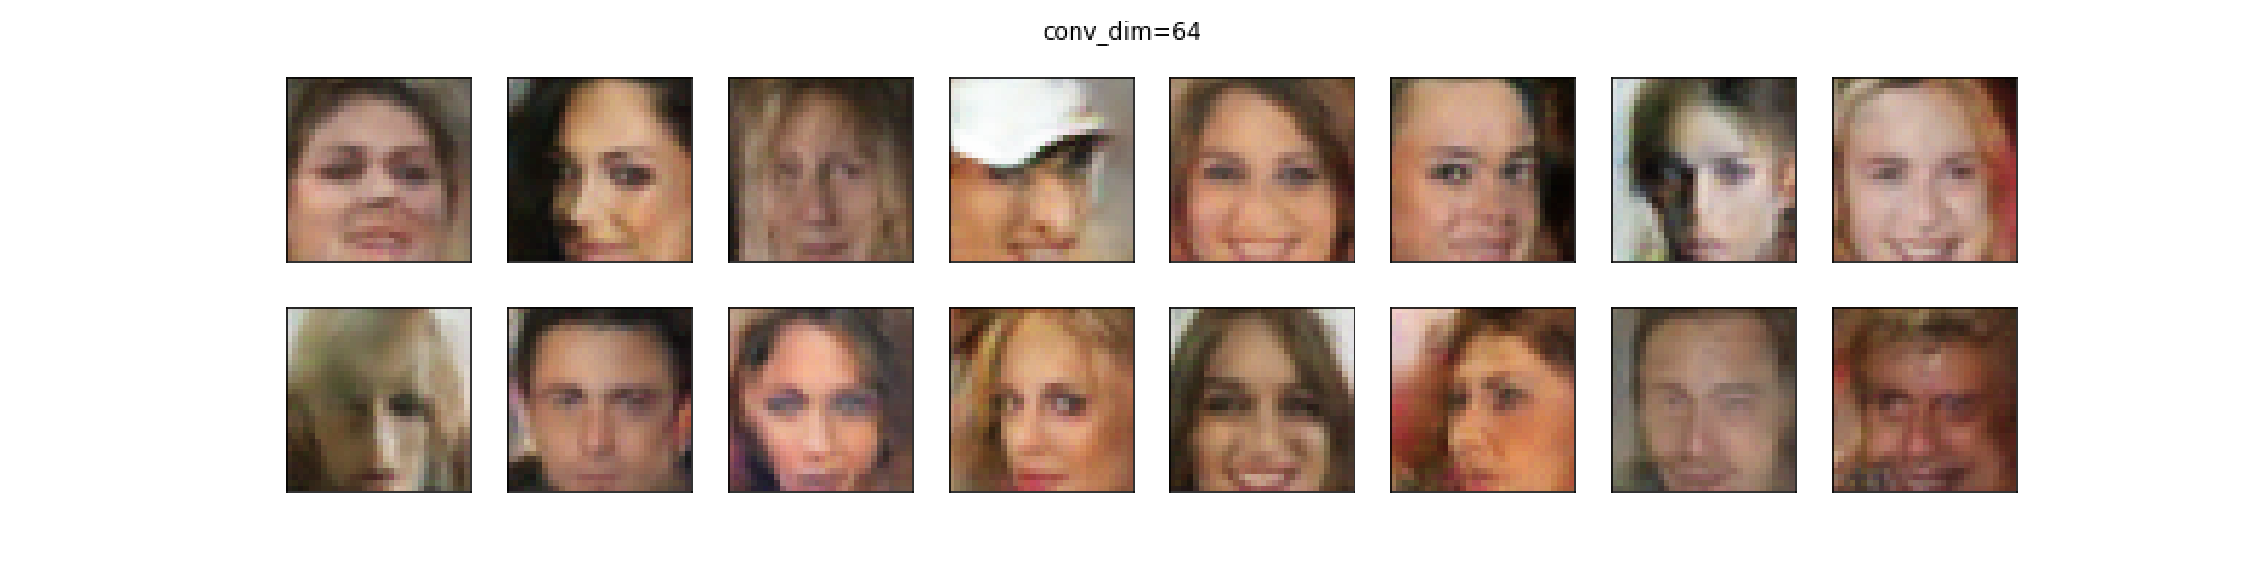

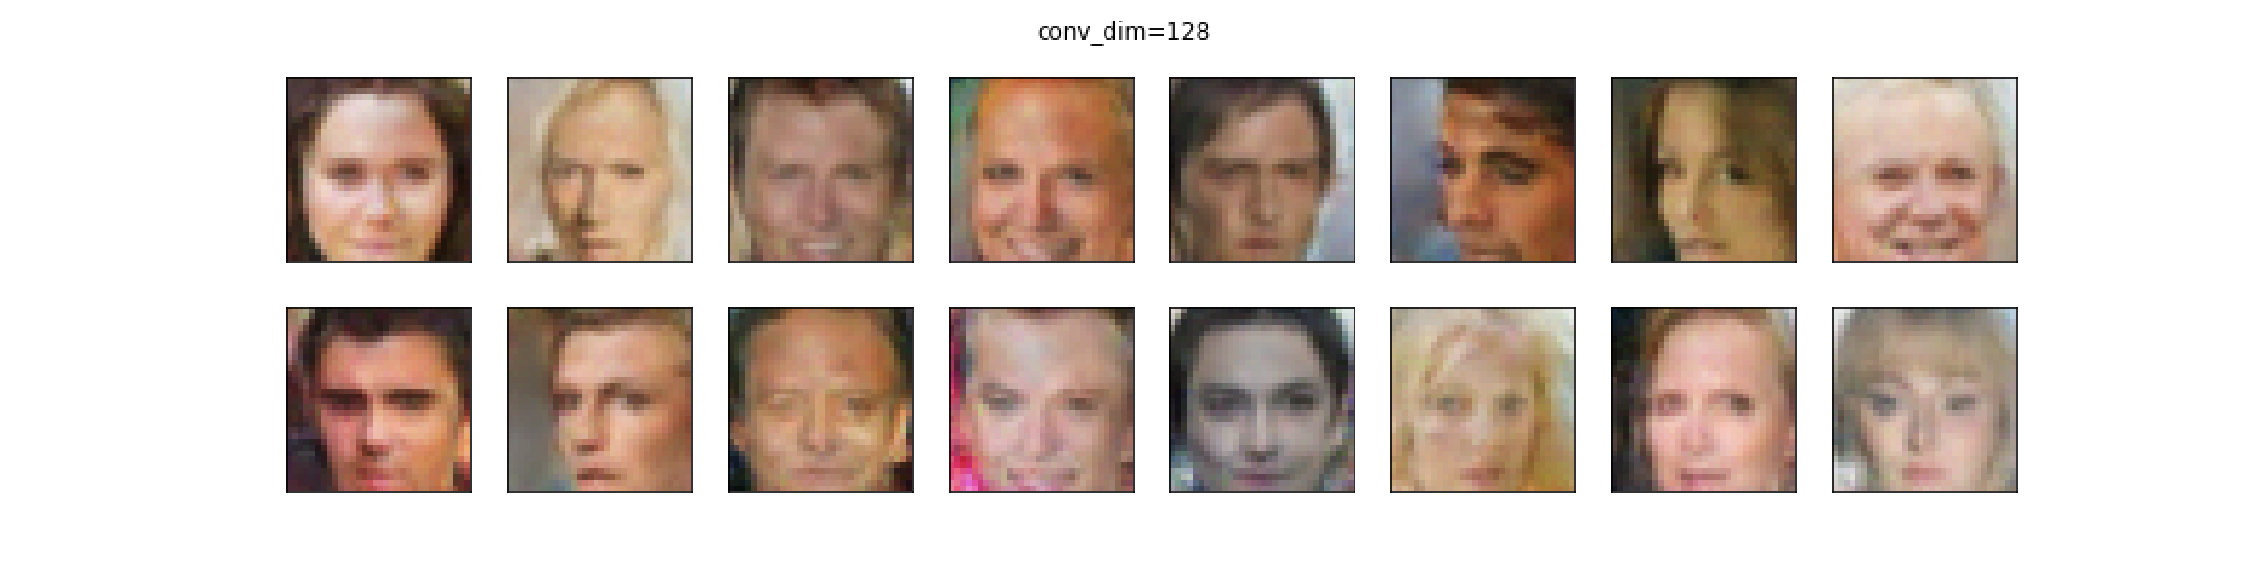

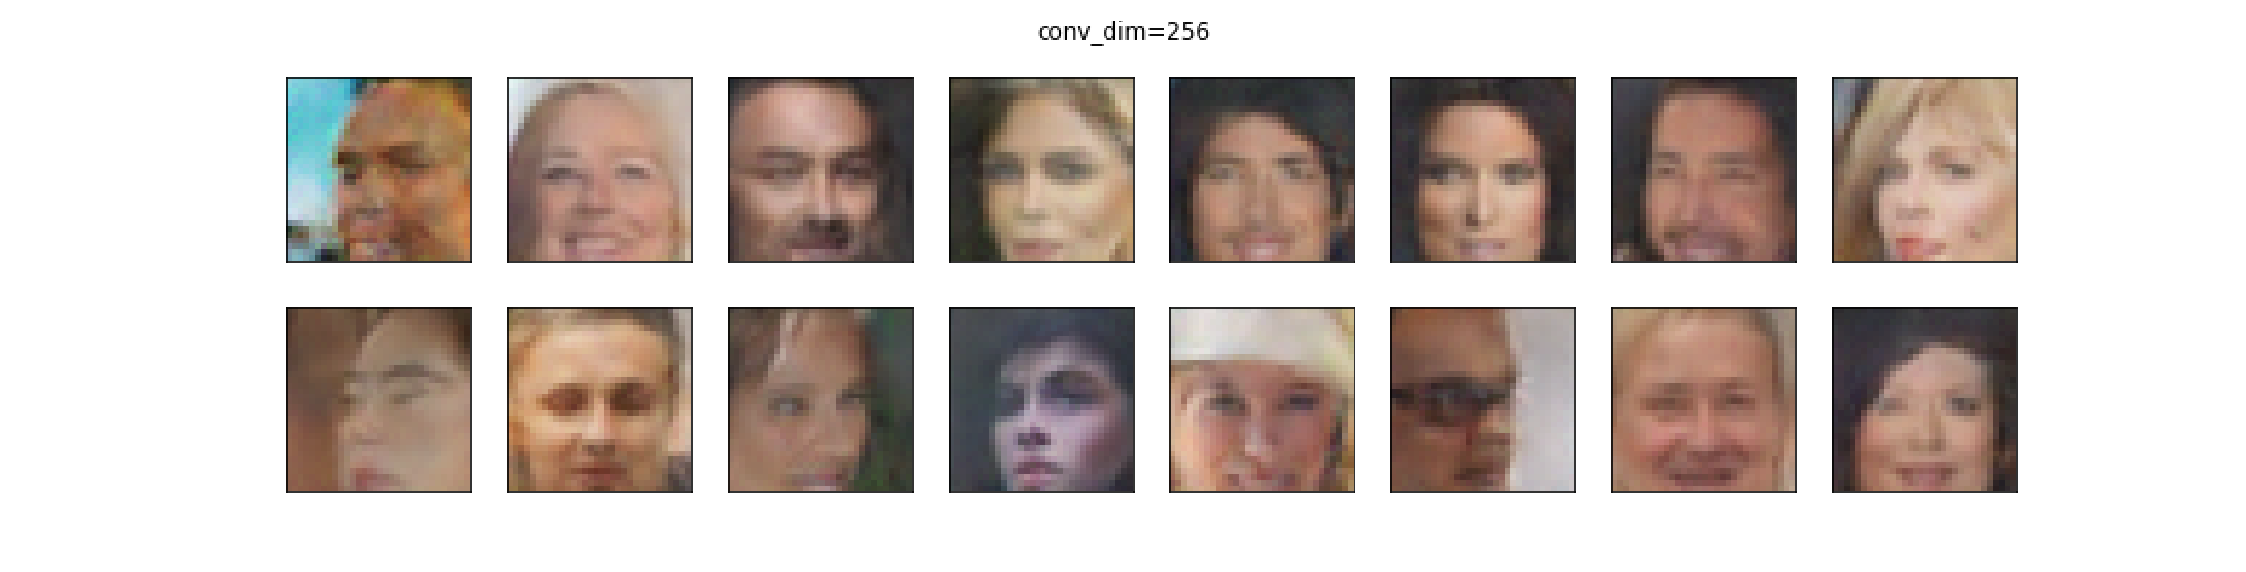

In [34]:
# conv_dim= 32, 64 , 128, 256
parameter_list_name = ['conv_dim=32', 'conv_dim=64','conv_dim=128', 'conv_dim=256']
train_num_list = [8, 11, 12, 13]
param_list = ['conv_deconv', 'conv_dim', 'conv_dim', 'conv_dim']
epoch_list = [100, 100, 100, 100]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param+ '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

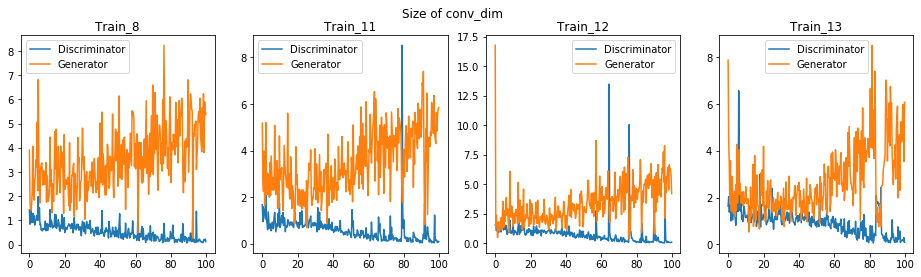

In [35]:
view_plots([[8, 'conv_deconv', 3],
            [11, 'conv_dim', 3],
            [12, 'conv_dim', 3],
            [13, 'conv_dim', 3]], 'Size of conv_dim', 'conv_dim') 

#### Result for parameter conv_dim:
With a higher conv_dim for the Generator and the Discriminator the resolution of feature details is getting higher. For example, eyes are better resolved with a conv_dim=256 than with a conv_dim=32. However, even a conv_dim of 64 leads to convincing results.

<a id='Parameter_lr'></a>

## Parameter: lr @ beta1=0.1	

Parameters          | 27th Train-Run| 28th Train-Run| 29th Train-Run | 
----------          | ------------- | ------------- | -------------  |
batch_size          |   32          |   32          |  32            |
img_size            |   32          |   32          |  32            |
deconv-layers       |   4           |   4           |  4             |
conv-layers         |   4           |   4           |  4             |
d_conv_dim          |   64          |   64          |  64            |
g_conv_dim          |   64          |   64          |  64            | 
z_size              |   100         |   100         |  100           | 
lr                  |   0.001       |   0.0005      |  0.0002        |   
beta1               |   0.1         |   0.1         |  0.1           |
beta2               |   0.999       |   0.999       |  0.999         |
dropout             |   yes         |   yes         |  yes           |
n_epochs            |   100         |   100         |  100           |

## Parameter: lr @ beta1=0.2	

Parameters          | 37th Train-Run| 39th Train-Run| 26th Train-Run | 
----------          | ------------- | ------------- | -------------  |
batch_size          |   32          |   32          |  32            |
img_size            |   32          |   32          |  32            |
deconv-layers       |   4           |   4           |  4             |
conv-layers         |   4           |   4           |  4             |
d_conv_dim          |   64          |   64          |  64            |
g_conv_dim          |   64          |   64          |  64            | 
z_size              |   100         |   100         |  100           | 
lr                  |   0.001       |   0.0005      |  0.0002        |   
beta1               |   0.2         |   0.2         |  0.2           |
beta2               |   0.999       |   0.999       |  0.999         |
dropout             |   yes         |   yes         |  yes           |
n_epochs            |   100         |   100         |  100           |

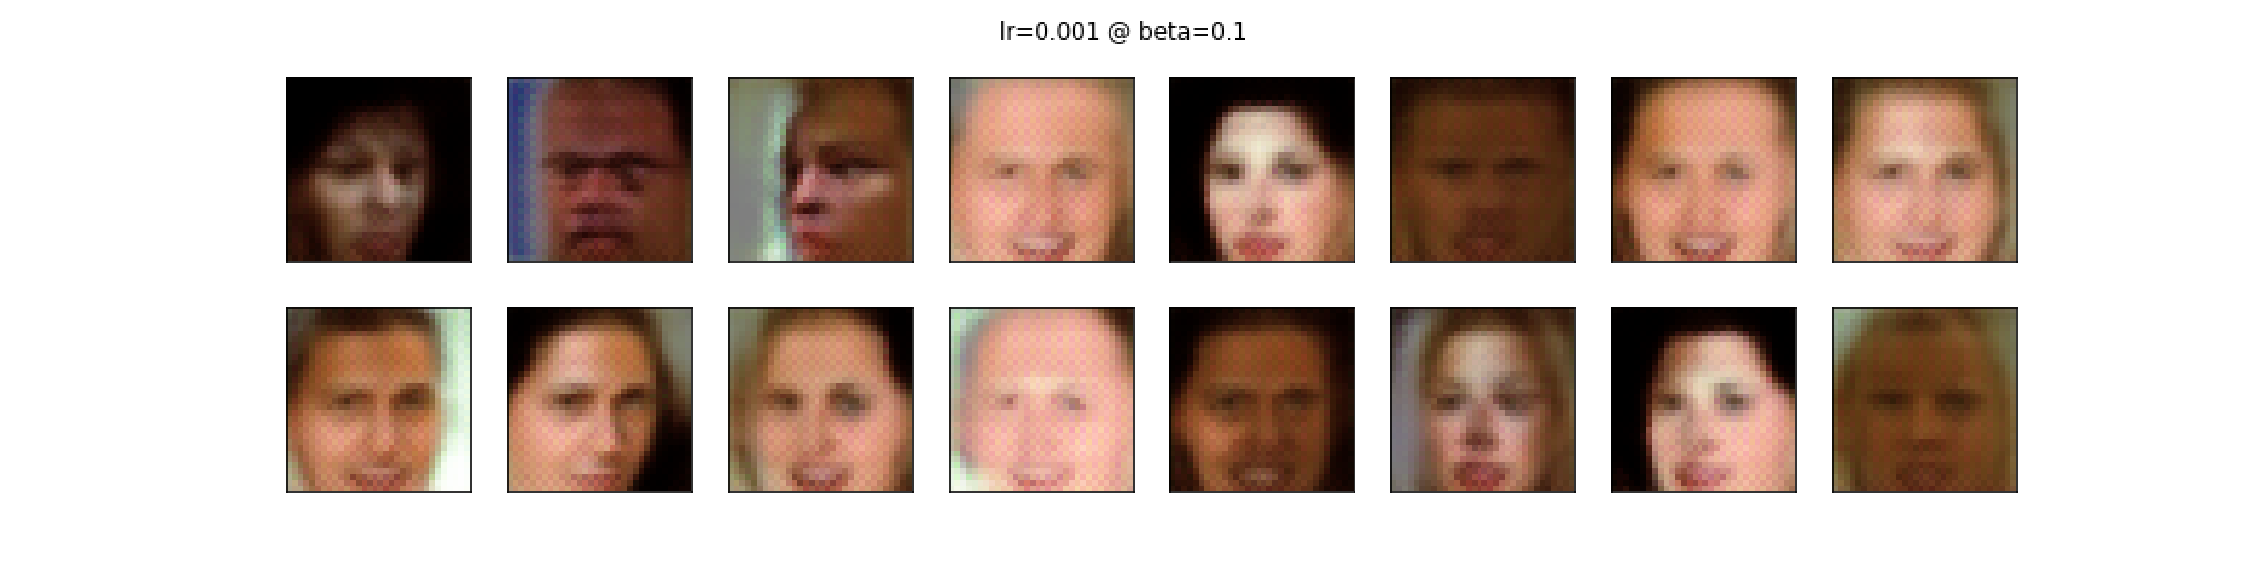

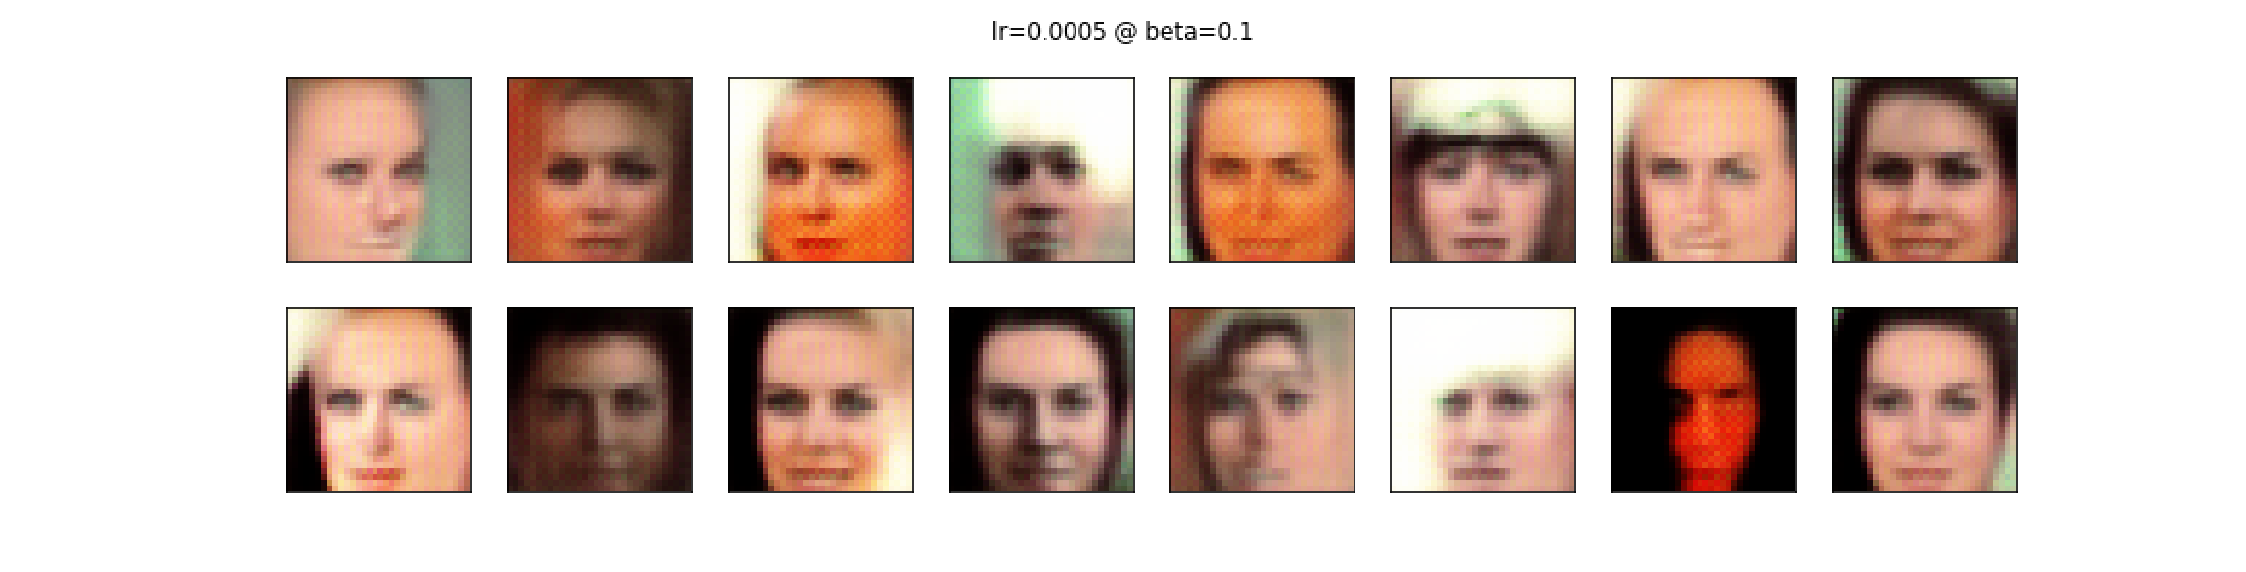

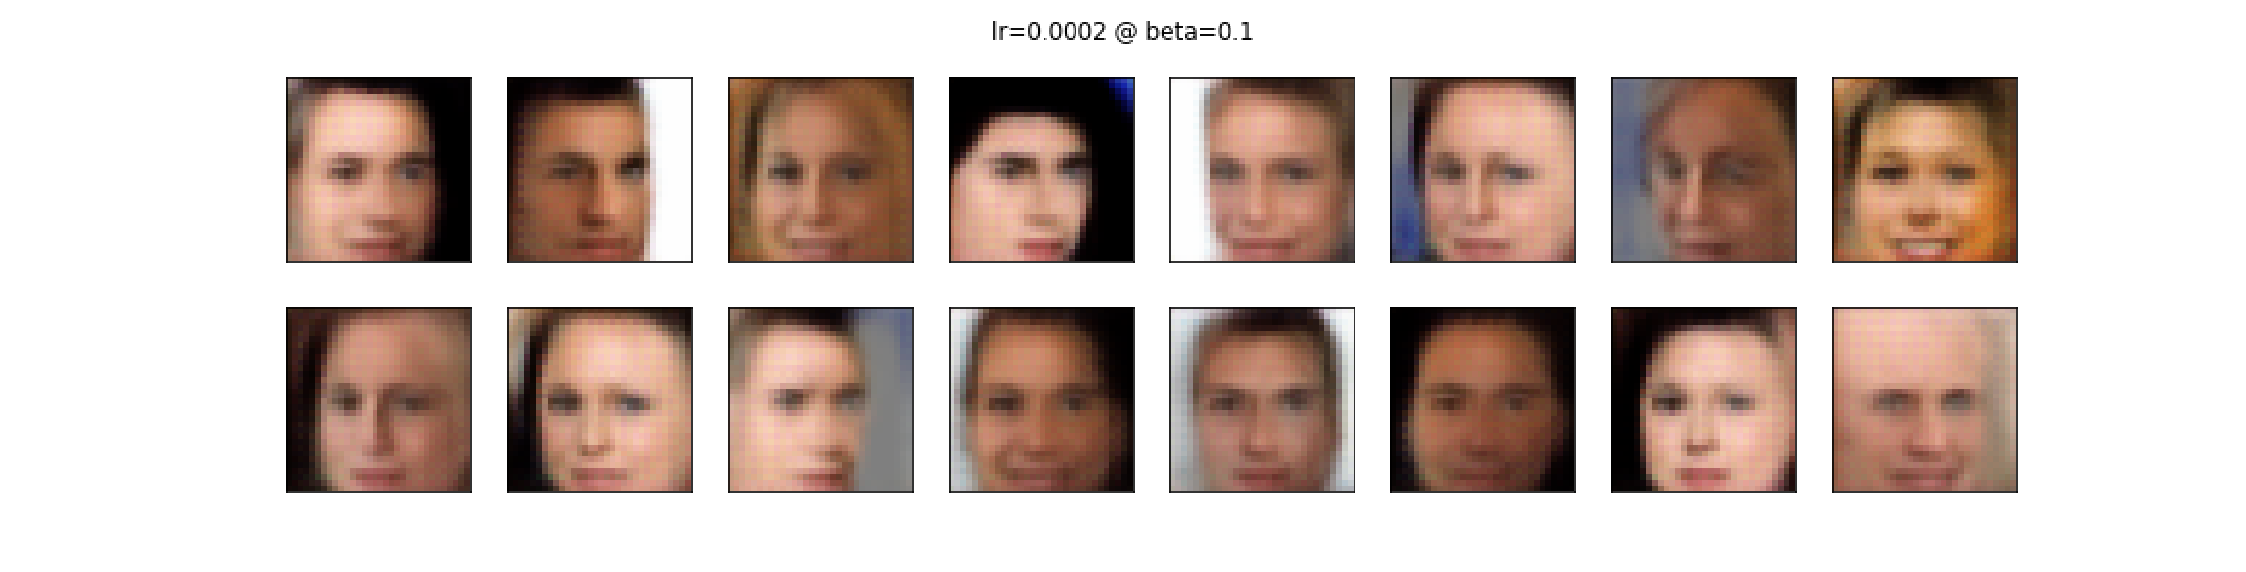

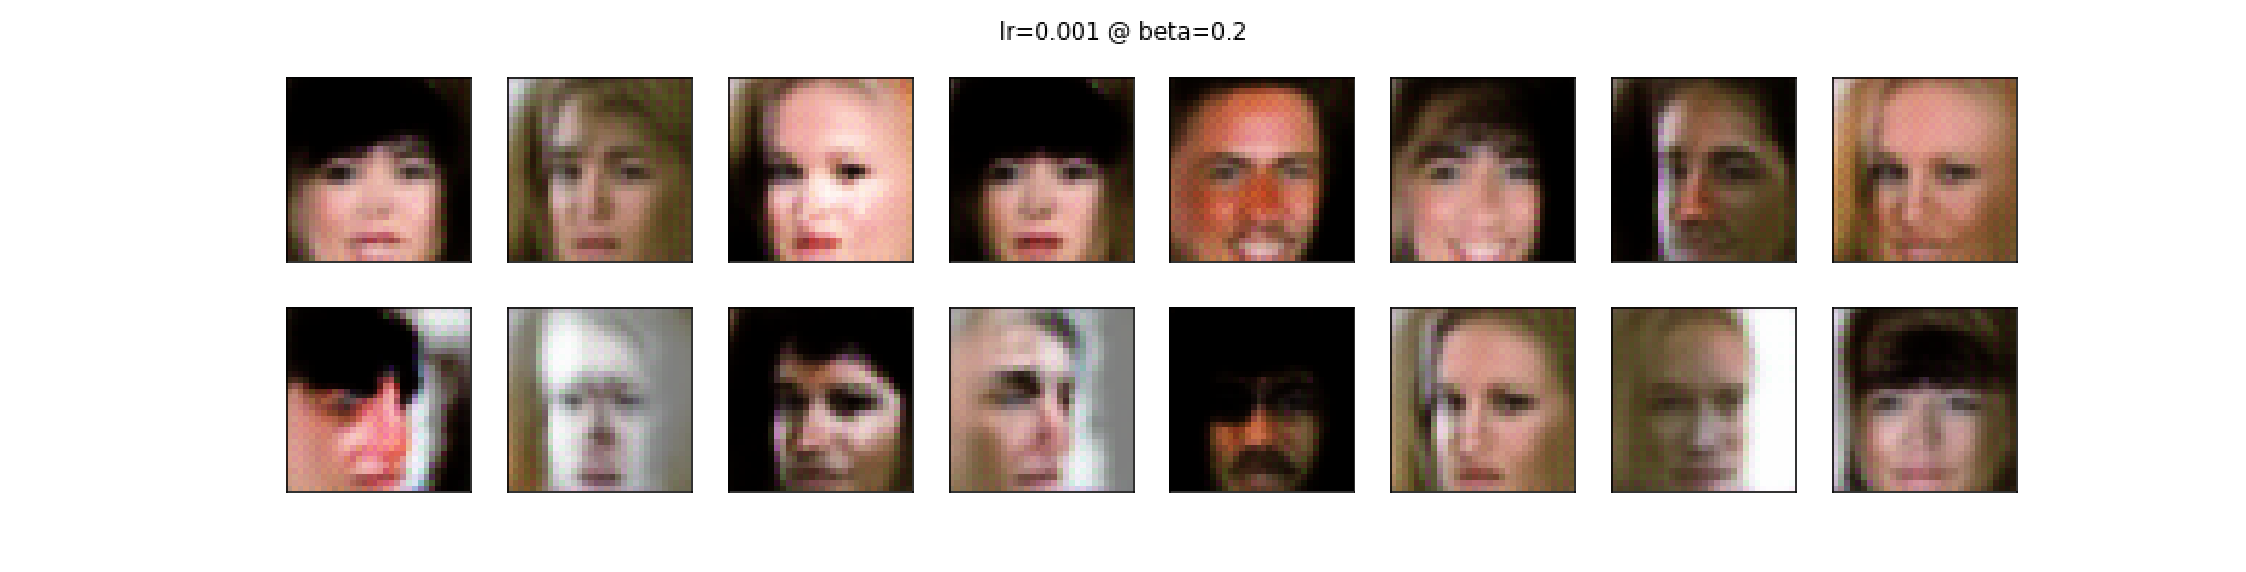

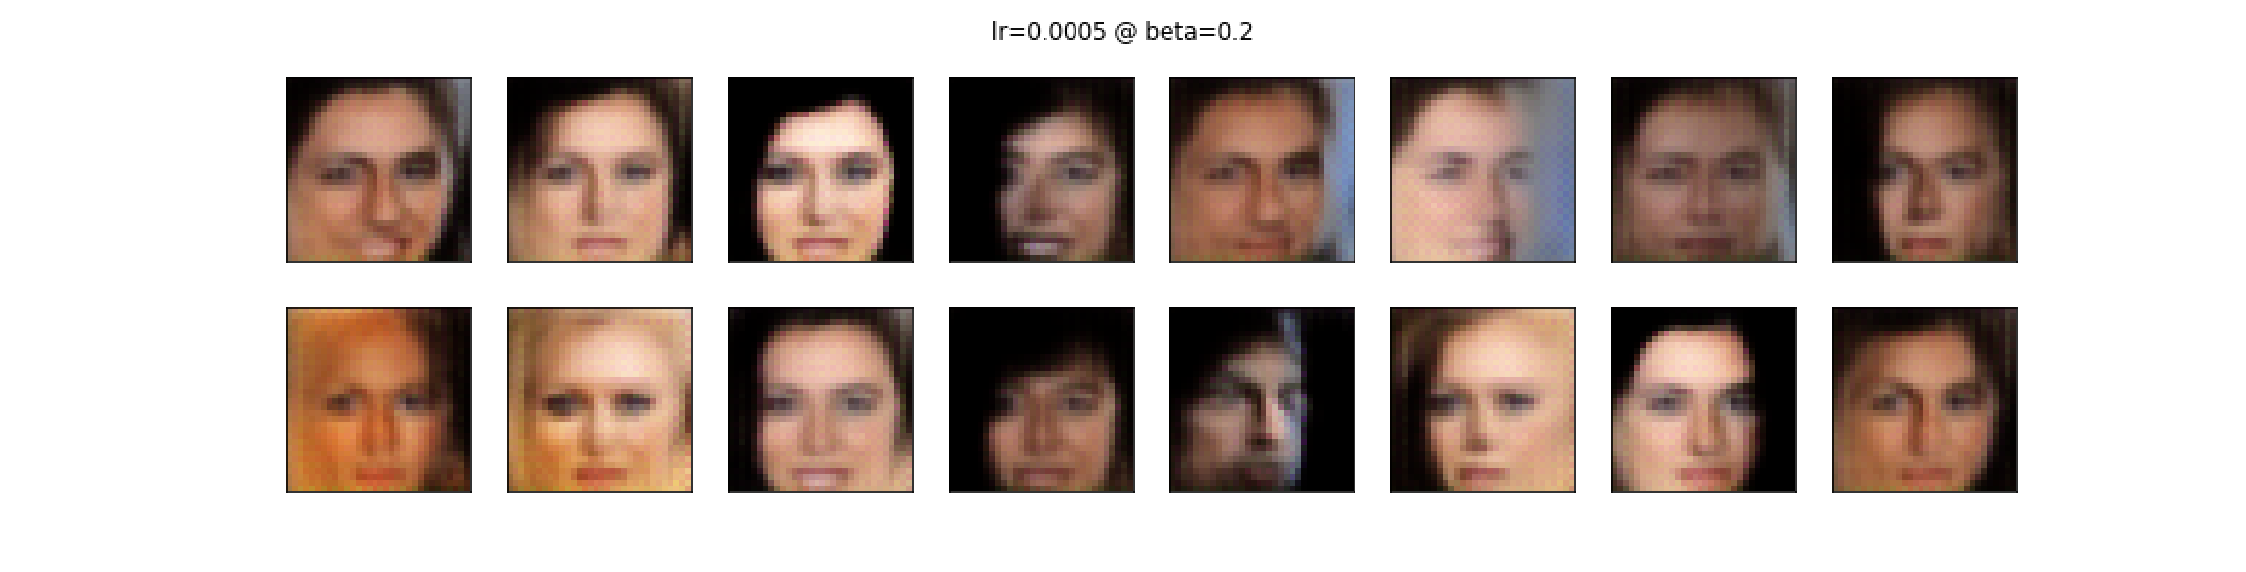

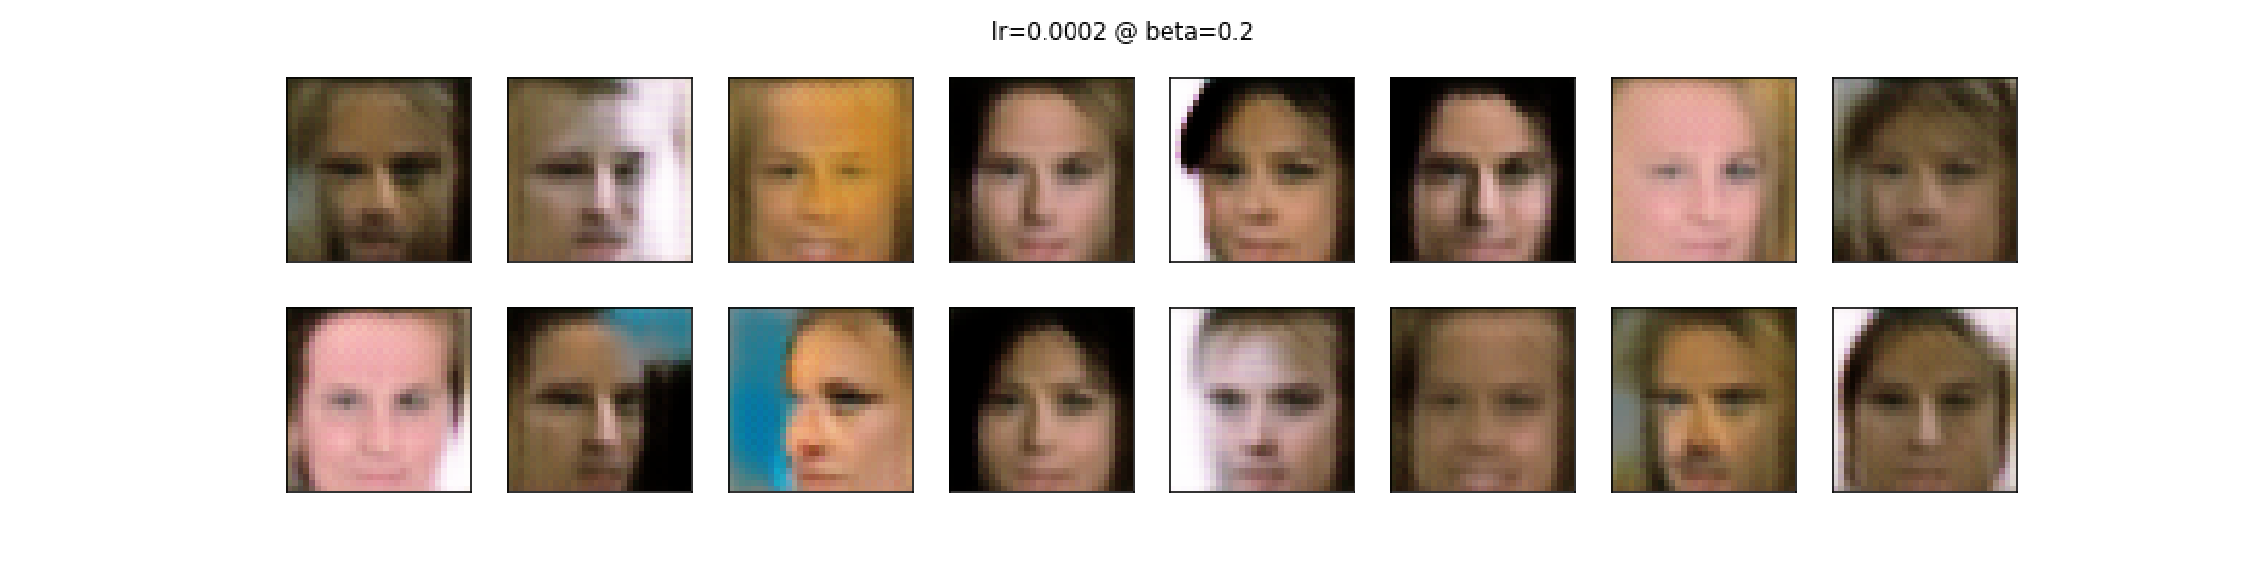

In [44]:
# lr=0.001, 0.0005, 0.0002 @ beta1=0.1
parameter_list_name = ['lr=0.001 @ beta=0.1','lr=0.0005 @ beta=0.1', 'lr=0.0002 @ beta=0.1']
train_num_list = [27, 28, 29]
param_list = ['lr', 'lr', 'lr']
epoch_list = [100, 100, 100]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)
    
# lr=0.001, 0.0005, 0.0002 @ beta1=0.2
parameter_list_name = ['lr=0.001 @ beta=0.2','lr=0.0005 @ beta=0.2', 'lr=0.0002 @ beta=0.2']
train_num_list = [37, 39, 26]
param_list = ['batch_size', 'batch_size', 'lr']
epoch_list = [100, 100, 100]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

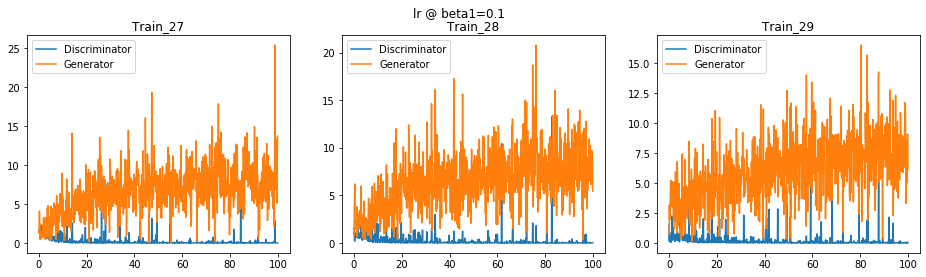

In [45]:
view_plots([[27, 'lr', 9],
            [28, 'lr', 9],
            [29, 'lr', 9]],'lr @ beta1=0.1', 'lr')   

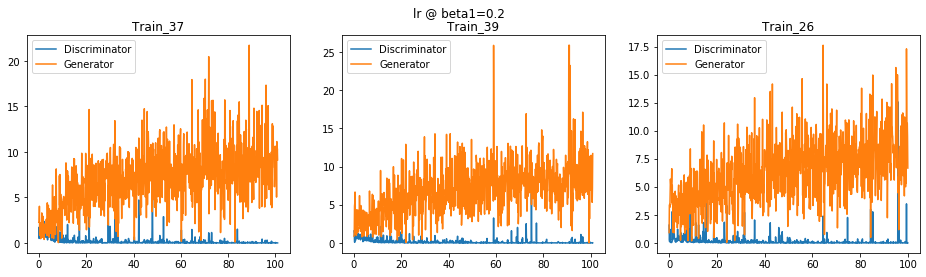

In [46]:
view_plots([[37, 'batch_size', 9],
            [39, 'batch_size', 9],
            [26, 'lr', 9]],'lr @ beta1=0.2', 'beta1') 

### Result for parameter lr:
Learning rates in the range between 0.01 and 0.0001 were tested. In all cases the GAN is able to learn and generated fake images of faces are successfully constructed. However, a learning rate of lr=0.0002 leads to best results. As the choice of batch_size has to be done with an appropriate learning rate, learning rates were also studied in combination with different values for <a href='#Parameter_batch_size'>batch_size</a> as well as for <a href='#Parameter_beta1'>beta1</a>.

<a id='Parameter_batch_size'></a>

## Parameter: batch_size @ lr=0.0002

Parameters          | 24th Train-Run| 26th Train-Run| 36th Train-Run|
----------          | ------------- | ------------- | ------------- | 
batch_size          |   16          |   32          |   64          | 
img_size            |   32          |   32          |   32          | 
deconv-layers       |   4           |   4           |   4           | 
conv-layers         |   4           |   4           |   4           |  
d_conv_dim          |   64          |   64          |   64          |
g_conv_dim          |   64          |   64          |   64          |  
z_size              |   100         |   100         |   100         | 
lr                  |   0.0002      |   0.0002      |   0.0002      |  
beta1               |   0.2         |   0.2         |   0.2         | 
beta2               |   0.999       |   0.999       |   0.999       | 
dropout             |   yes         |   yes         |   yes         | 
n_epochs            |   100         |   100         |   100         |  

## Parameter: batch_size @ lr=0.0005

Parameters          | 38th Train-Run| 39th Train-Run| 40th Train-Run|
----------          | ------------- | ------------- | ------------- | 
batch_size          |   16          |   32          |   64          | 
img_size            |   32          |   32          |   32          | 
deconv-layers       |   4           |   4           |   4           | 
conv-layers         |   4           |   4           |   4           |  
d_conv_dim          |   64          |   64          |   64          |
g_conv_dim          |   64          |   64          |   64          |  
z_size              |   100         |   100         |   100         | 
lr                  |   0.0005      |   0.0005      |   0.0005      |  
beta1               |   0.2         |   0.2         |   0.2         | 
beta2               |   0.999       |   0.999       |   0.999       | 
dropout             |   yes         |   yes         |   yes         | 
n_epochs            |   100         |   100         |   100         |   

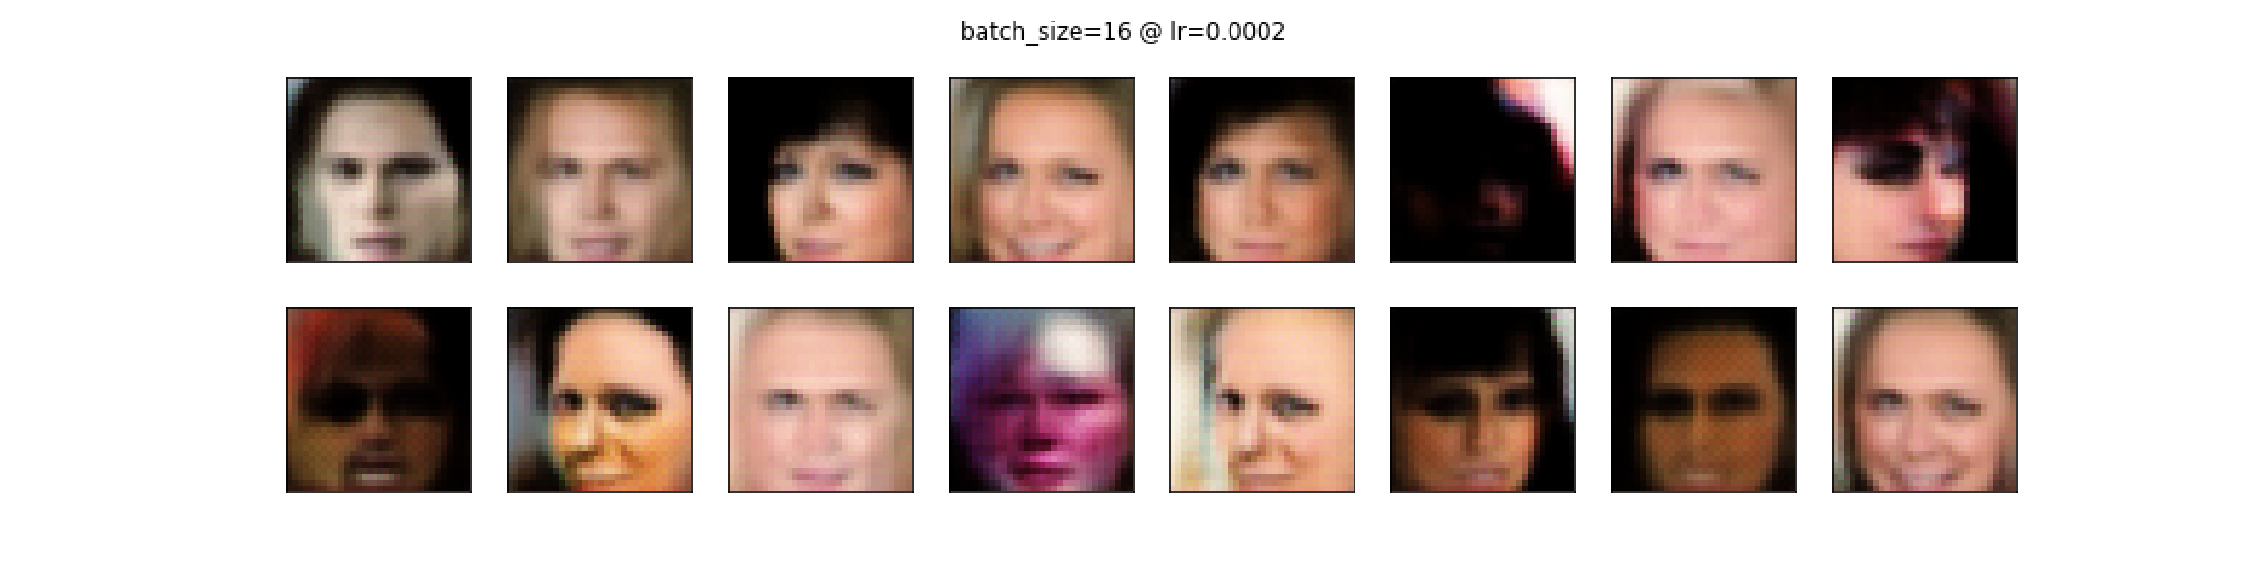

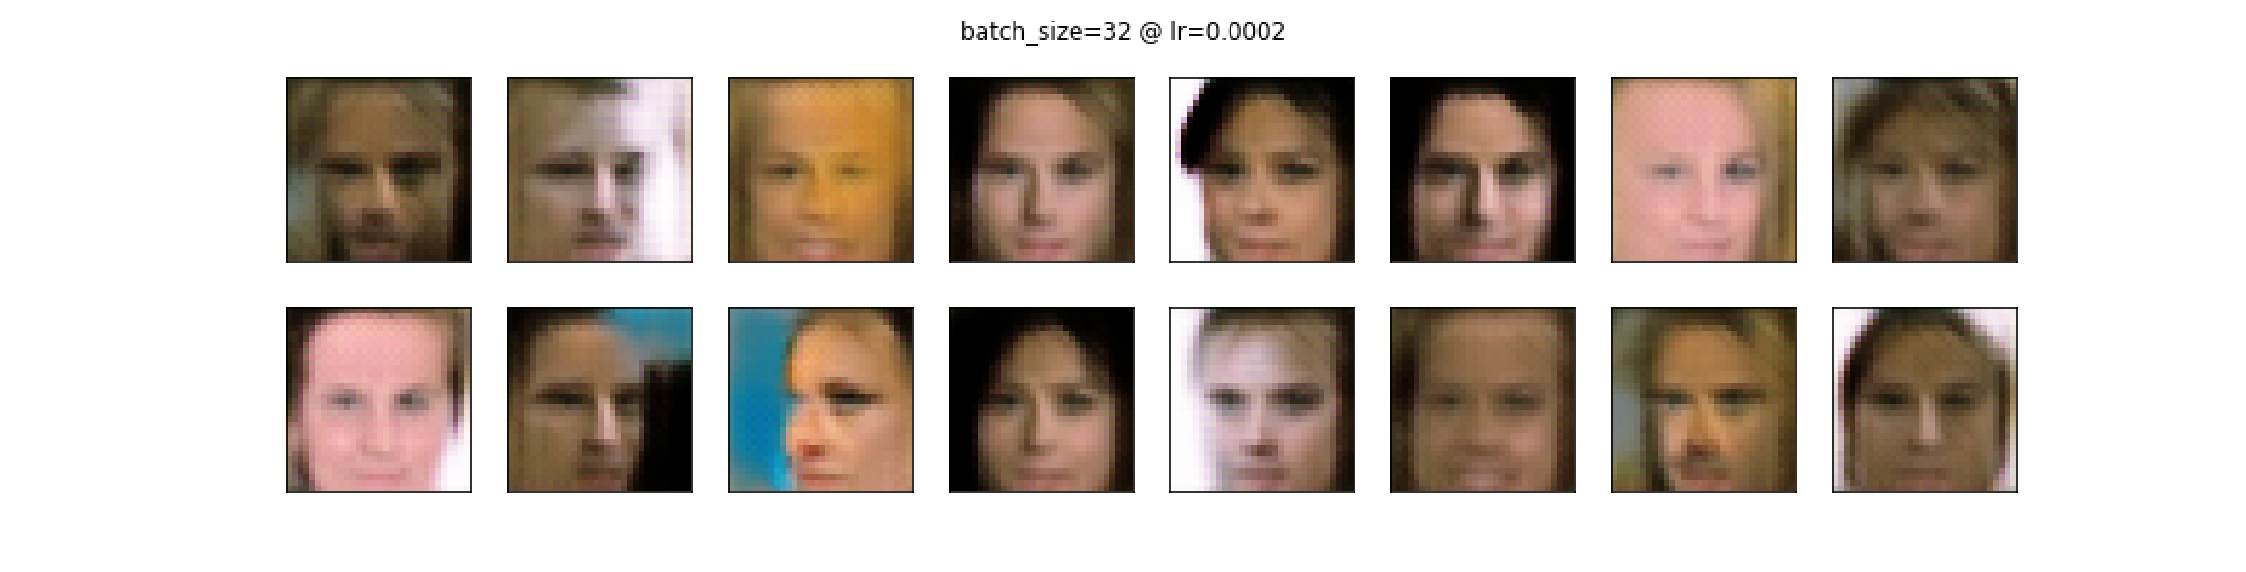

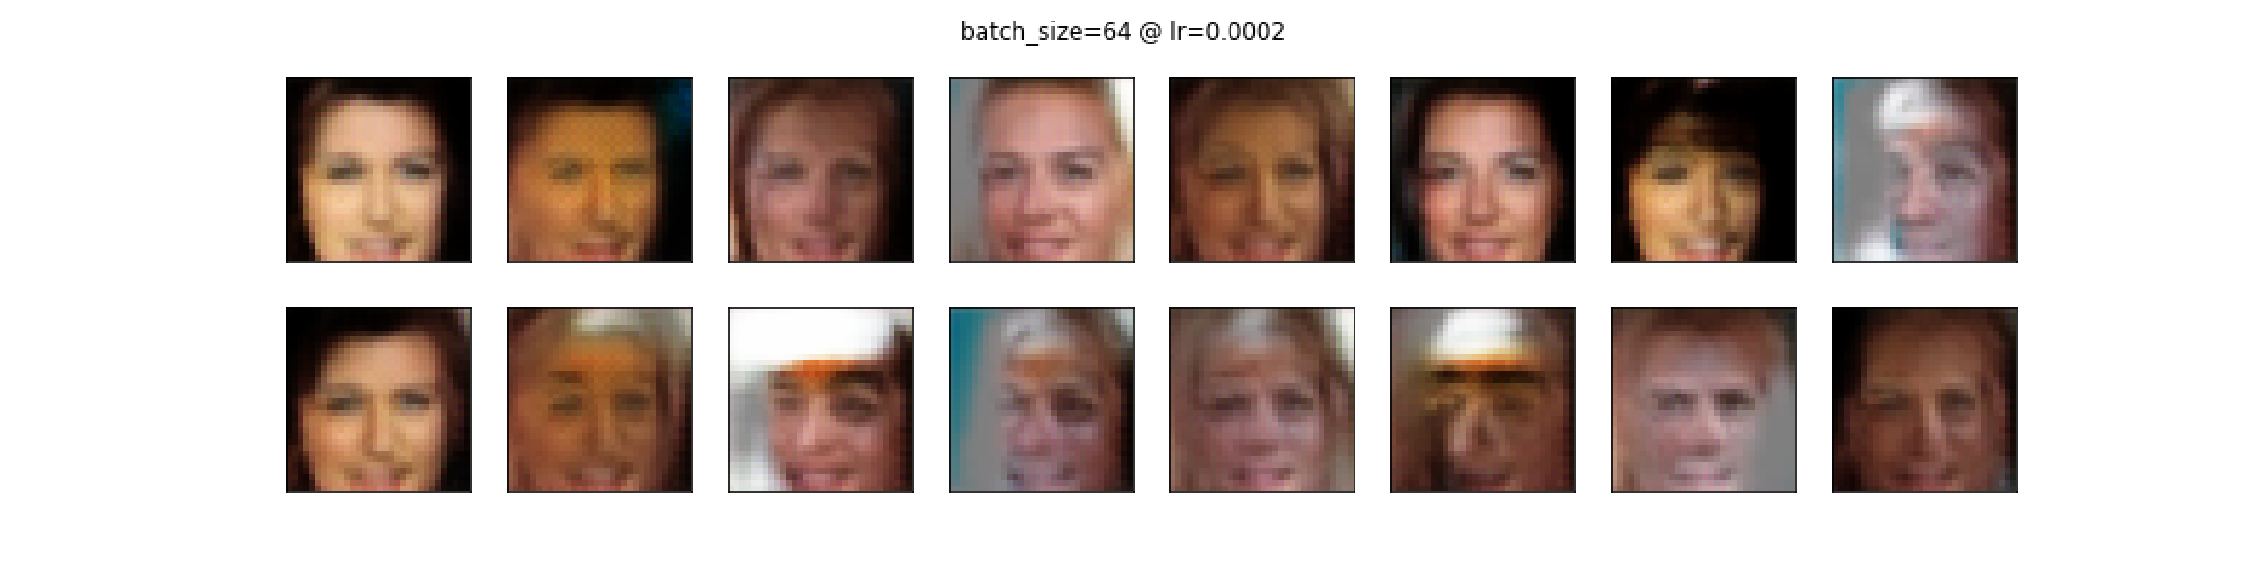

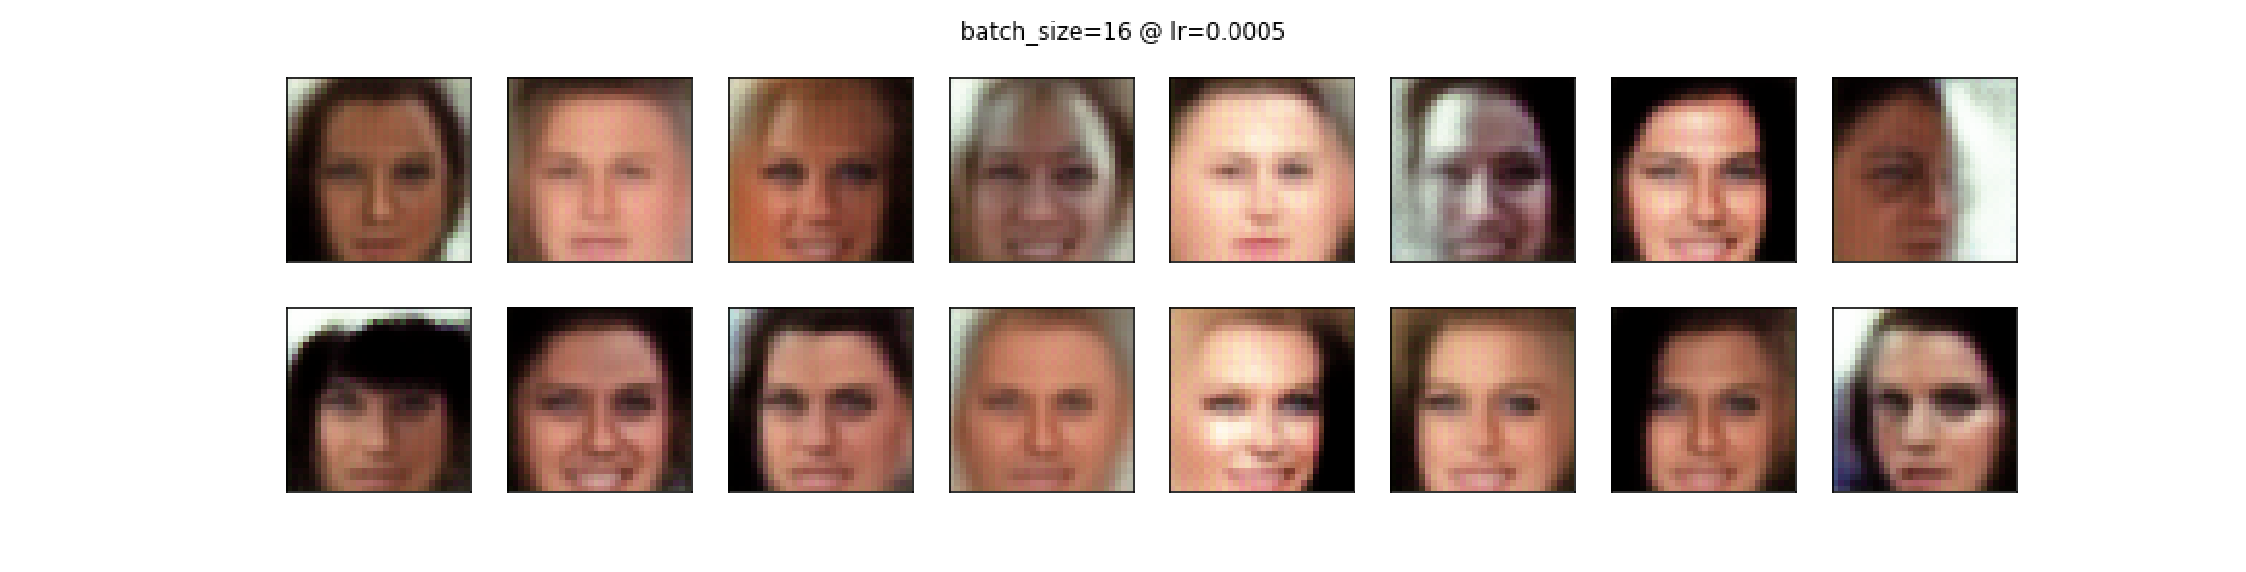

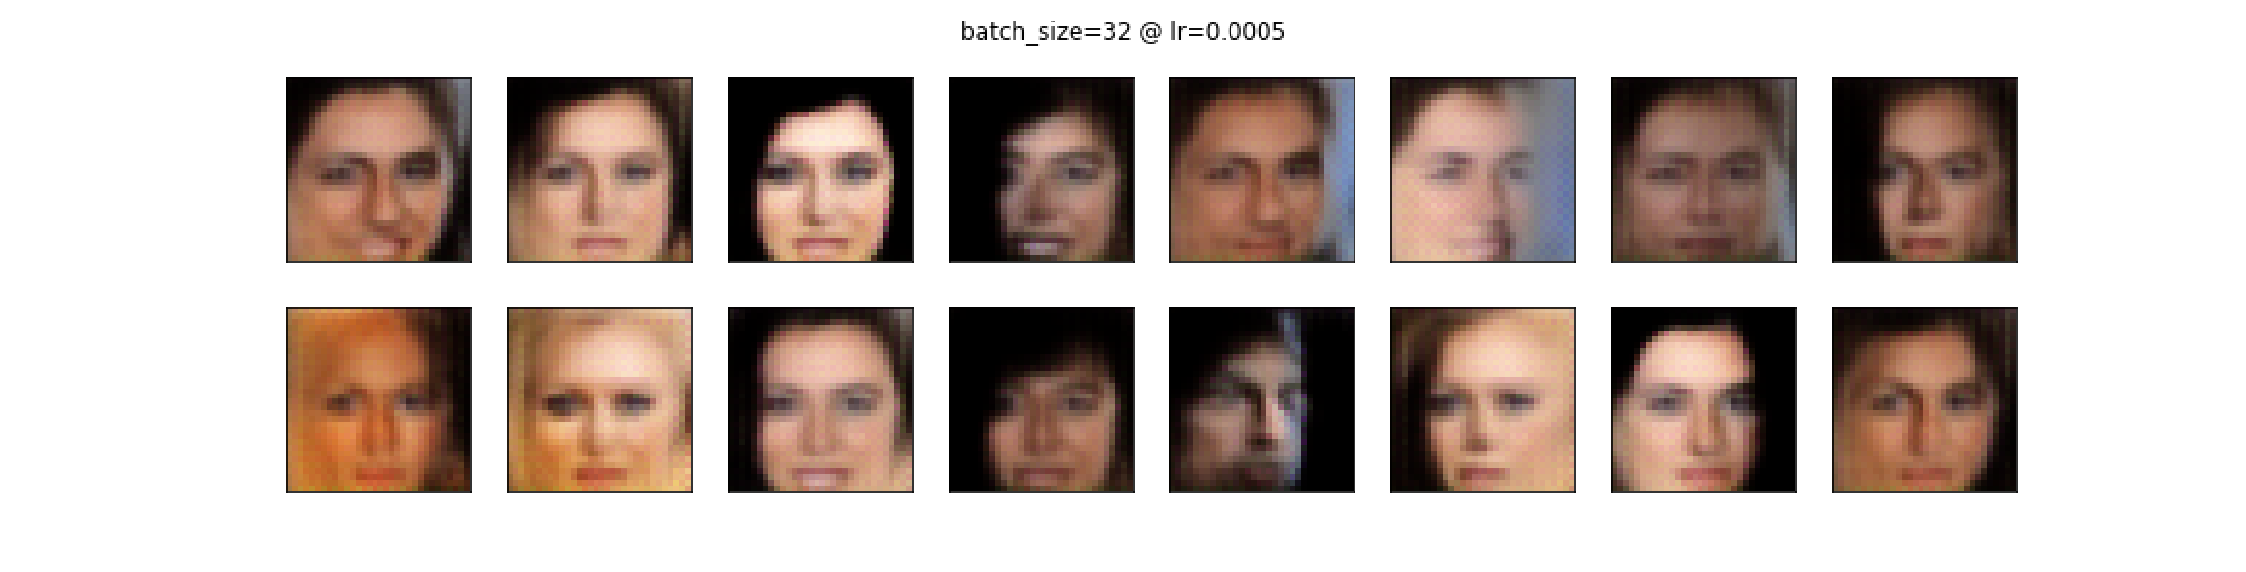

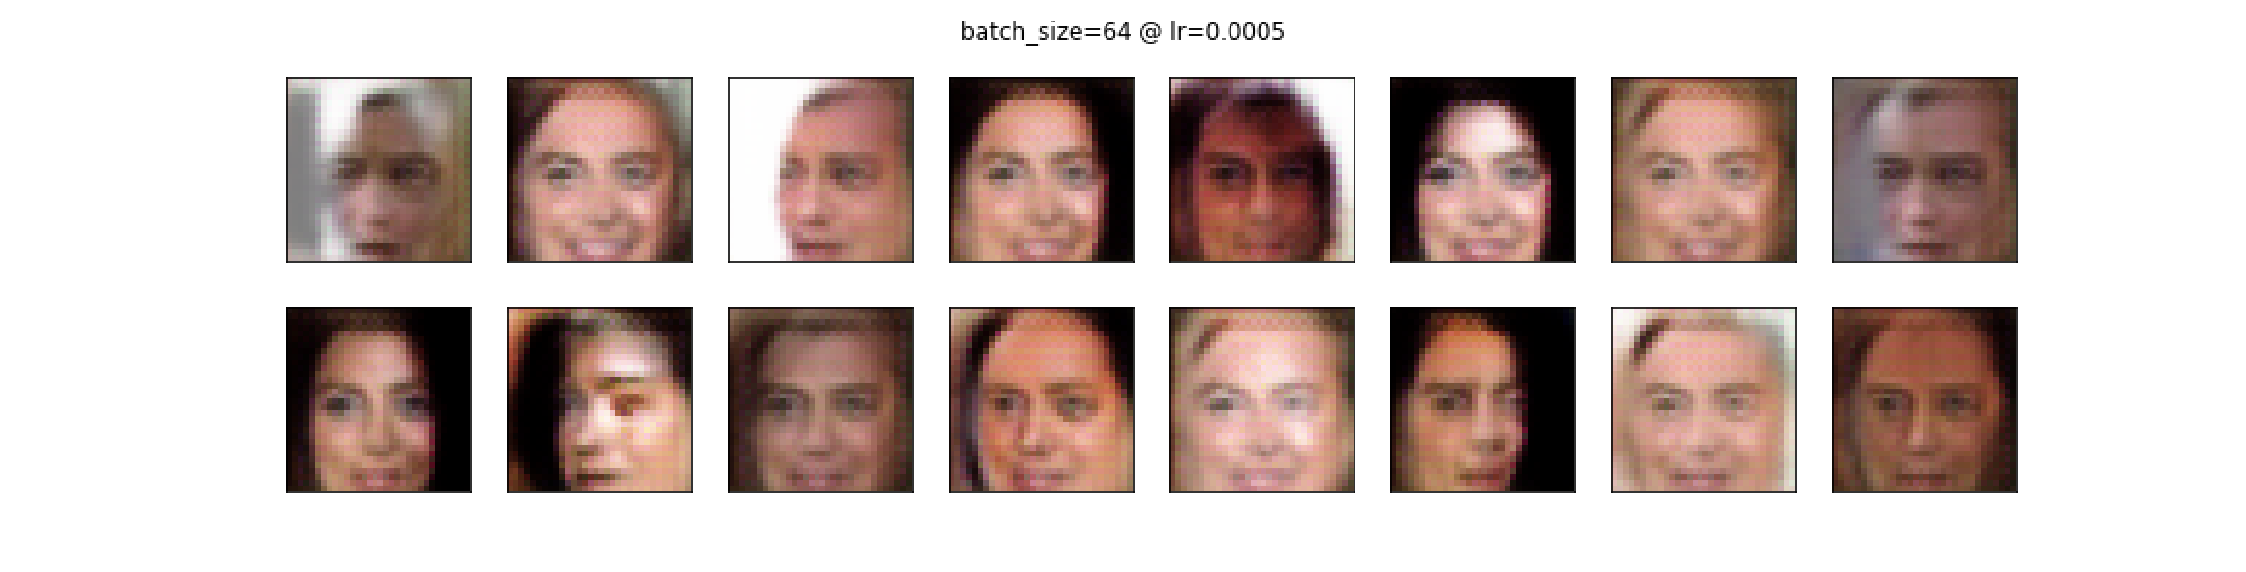

In [47]:
# batch_size=16, 32, 64 @ lr=0.0002
parameter_list_name = ['batch_size=16 @ lr=0.0002','batch_size=32 @ lr=0.0002', 'batch_size=64 @ lr=0.0002']
train_num_list = [24, 26, 36]
param_list = ['lr', 'lr', 'batch_size']
epoch_list = [100, 100, 100]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)
    

# batch_size=16, 32, 64 @ lr=0.0005
parameter_list_name = ['batch_size=16 @ lr=0.0005','batch_size=32 @ lr=0.0005', 'batch_size=64 @ lr=0.0005']
train_num_list = [38, 39, 40]
param_list = ['batch_size', 'batch_size', 'batch_size']
epoch_list = [100, 100, 90]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

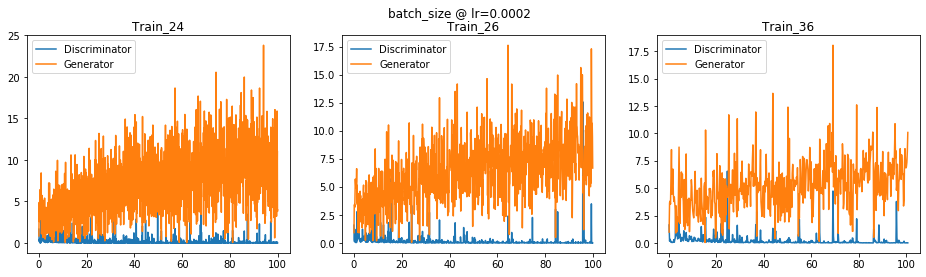

In [48]:
view_plots([[24, 'lr', 18],
            [26, 'lr', 9],
            [36, 'batch_size', 5]],'batch_size @ lr=0.0002', 'batch_size')

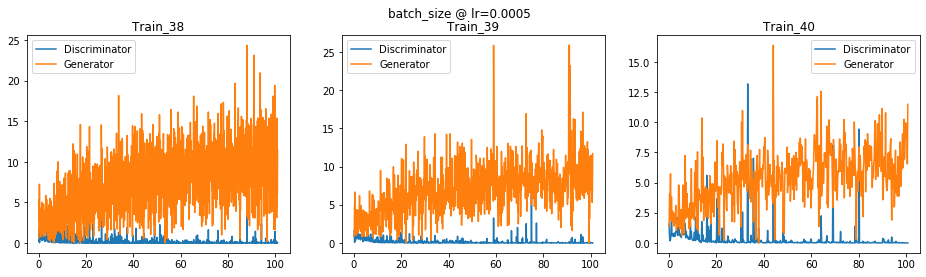

In [49]:
view_plots([[38, 'batch_size', 18],
            [39, 'batch_size', 9],
            [40, 'batch_size', 5]],'batch_size @ lr=0.0005', 'batch_size')

### Result for batch_size:
The value range for the batch_size was chosen between 16 and 512. A larger batch_size has a positive effect on the computational boost. However, if the batch_size is getting too high the feature resolution is getting worse (more blurred). If the batch_size is too small, then the gradients will become more unstable and would need to reduce the learning rate. So batch_size and learning rate lr are linked. The noisy loss for small batch_sizes can be used to overcome local minima during training. If one use a bigger batch_size, then the gradients will become less noisy (this can be clearly seen in the results above) but it will take longer to converge. Therefore a batch_size of 32 has been chosen. Up to a batch_size of 512 no out-of-memory errors were observed.

<a id='Parameter_beta1'></a>

## Parameter: beta1

Parameters          | 29th Train-Run| 26th Train-Run| 31th Train-Run | 
----------          | ------------- | ------------- | -------------  |
batch_size          |   32          |   32          |  32            |
img_size            |   32          |   32          |  32            |
deconv-layers       |   4           |   4           |  4             |
conv-layers         |   4           |   4           |  4             |
d_conv_dim          |   64          |   64          |  64            |
g_conv_dim          |   64          |   64          |  64            | 
z_size              |   100         |   100         |  100           | 
lr                  |   0.0002      |   0.0002      |  0.0002        |   
beta1               |   0.1         |   0.2         |  0.3           |
beta2               |   0.999       |   0.999       |  0.999         |
dropout             |   yes         |   yes         |  yes           |
n_epochs            |   100         |   100         |  100           |

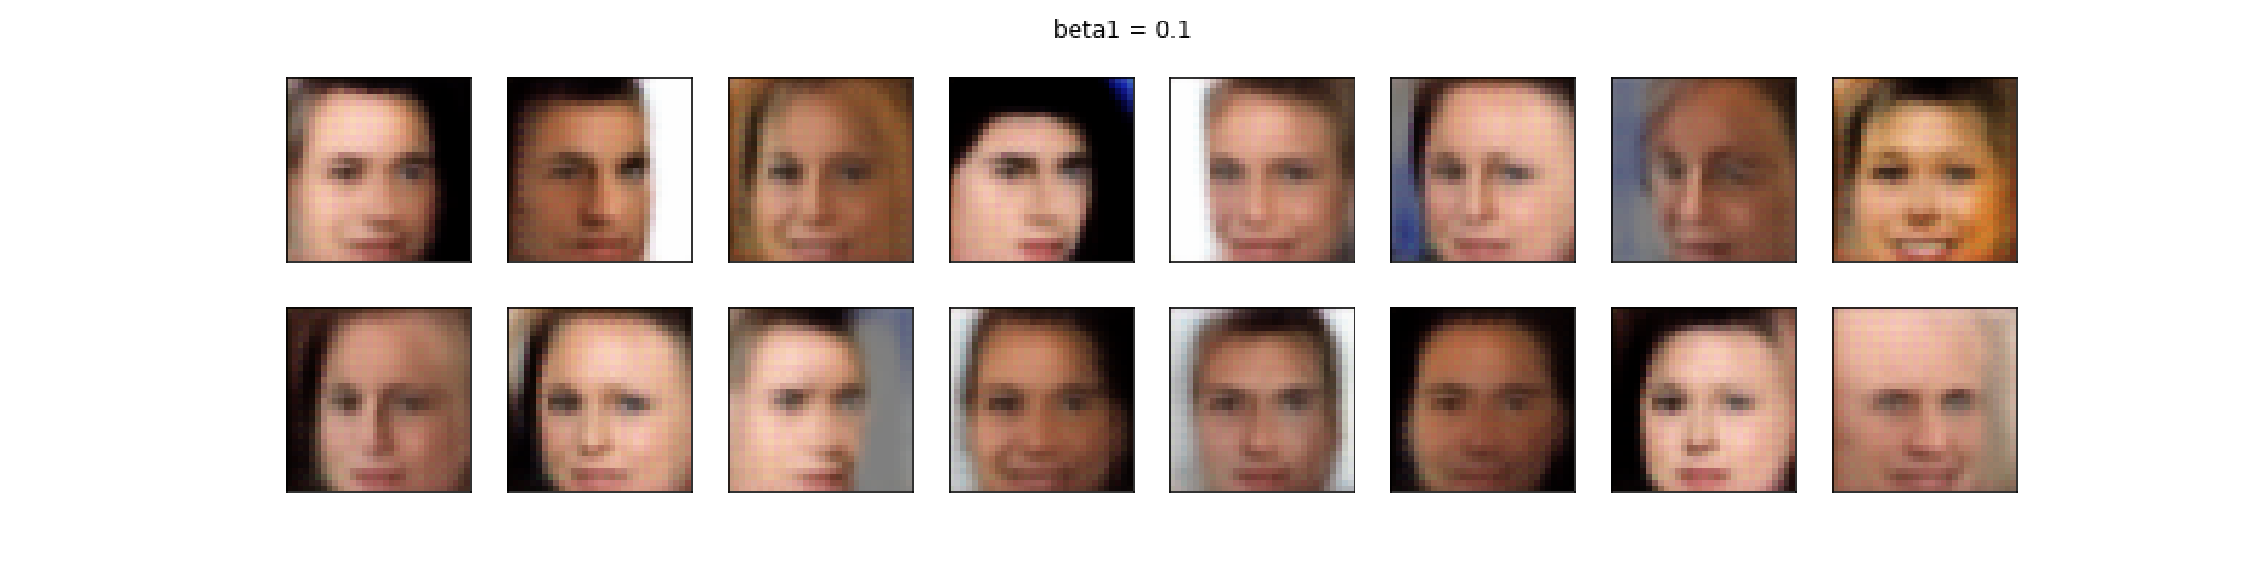

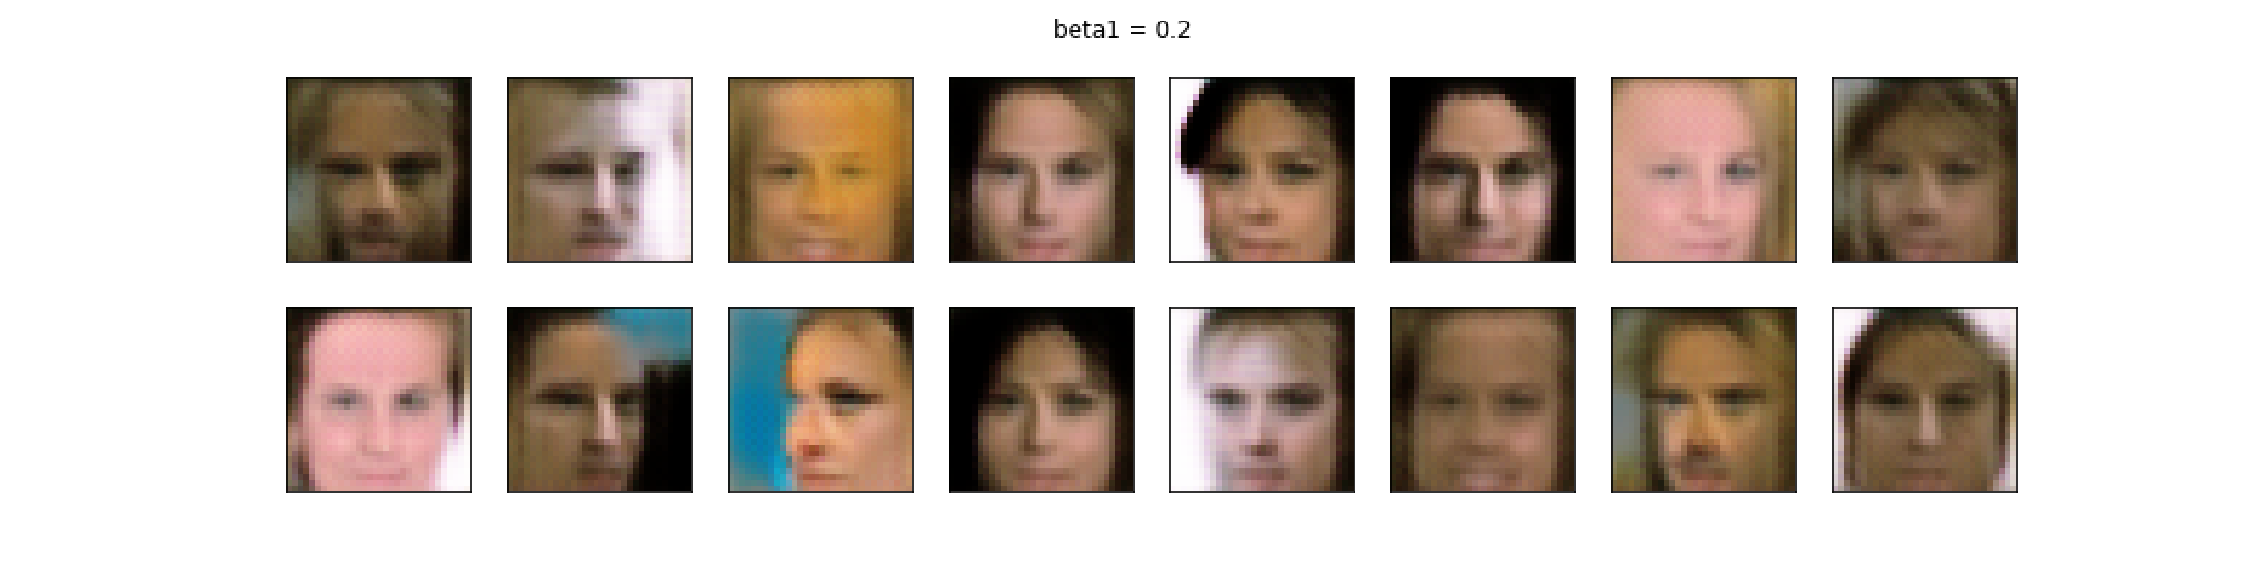

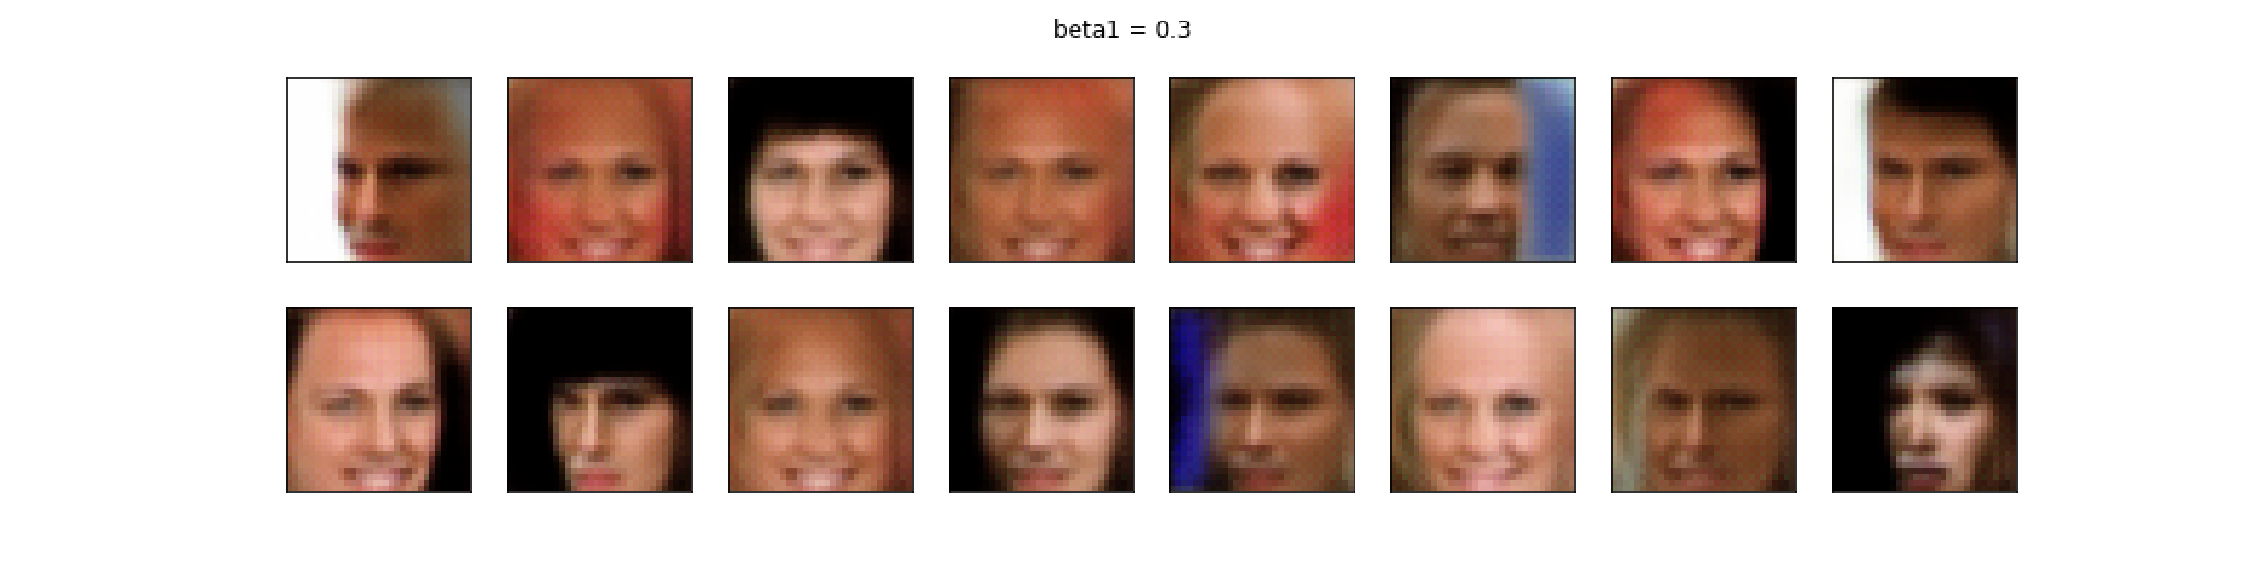

In [52]:
# beta1=0.1, 0.2, 0.3
parameter_list_name = ['beta1 = 0.1', 'beta1 = 0.2','beta1 = 0.3']
train_num_list = [29, 26, 31]
param_list = ['lr', 'lr', 'lr']
epoch_list = [100, 100, 100]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

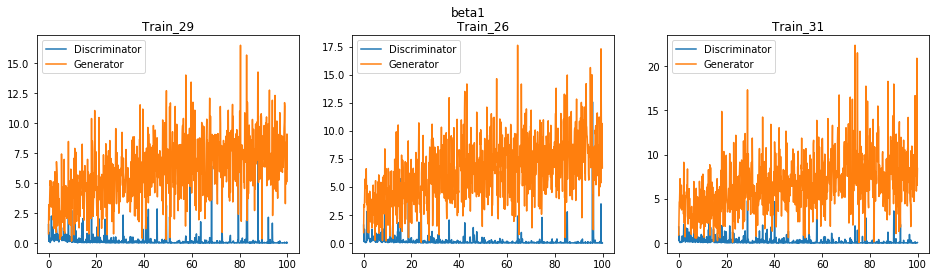

In [53]:
view_plots([[29, 'lr', 9],
            [26, 'lr', 9],
            [31, 'lr', 9]],'beta1', 'beta1')  

### Result for beta1:
Values for beta1 were investigated in the range between 0.1 to 0.5. It was found out that beta1 values in the range between 0.1 to 0.3 have shown to get best results for generated images.

<a id='Parameter_dropout'></a>

## Parameter: Dropout config
Parameters          | 41/32...35th Train-Run| 
----------          | ------------- | 
batch_size          |   32          |
img_size            |   32          |
deconv-layers       |   4           |
conv-layers         |   4           |
d_conv_dim          |   64          |
g_conv_dim          |   64          |
z_size              |   100         |
lr                  |   0.0002      |
beta1               |   0.2         |
beta2               |   0.999       |
dropout             |   no/yes      | 
n_epochs            |   100         |

In separate Training runs different settings of Dropout layers were tested. 
In Train41 no dropout layers were impmented whereas in Train32...35 different dropout probabilities of 0.5 and 0.2 and number of dropout layers were studied. For simplification of the model pictures below, ReLU activation and batch normalization layers are not shown but were implemented in the corresponding training runs. 

<img src='assets/Dropout_overview.png' width=90% />

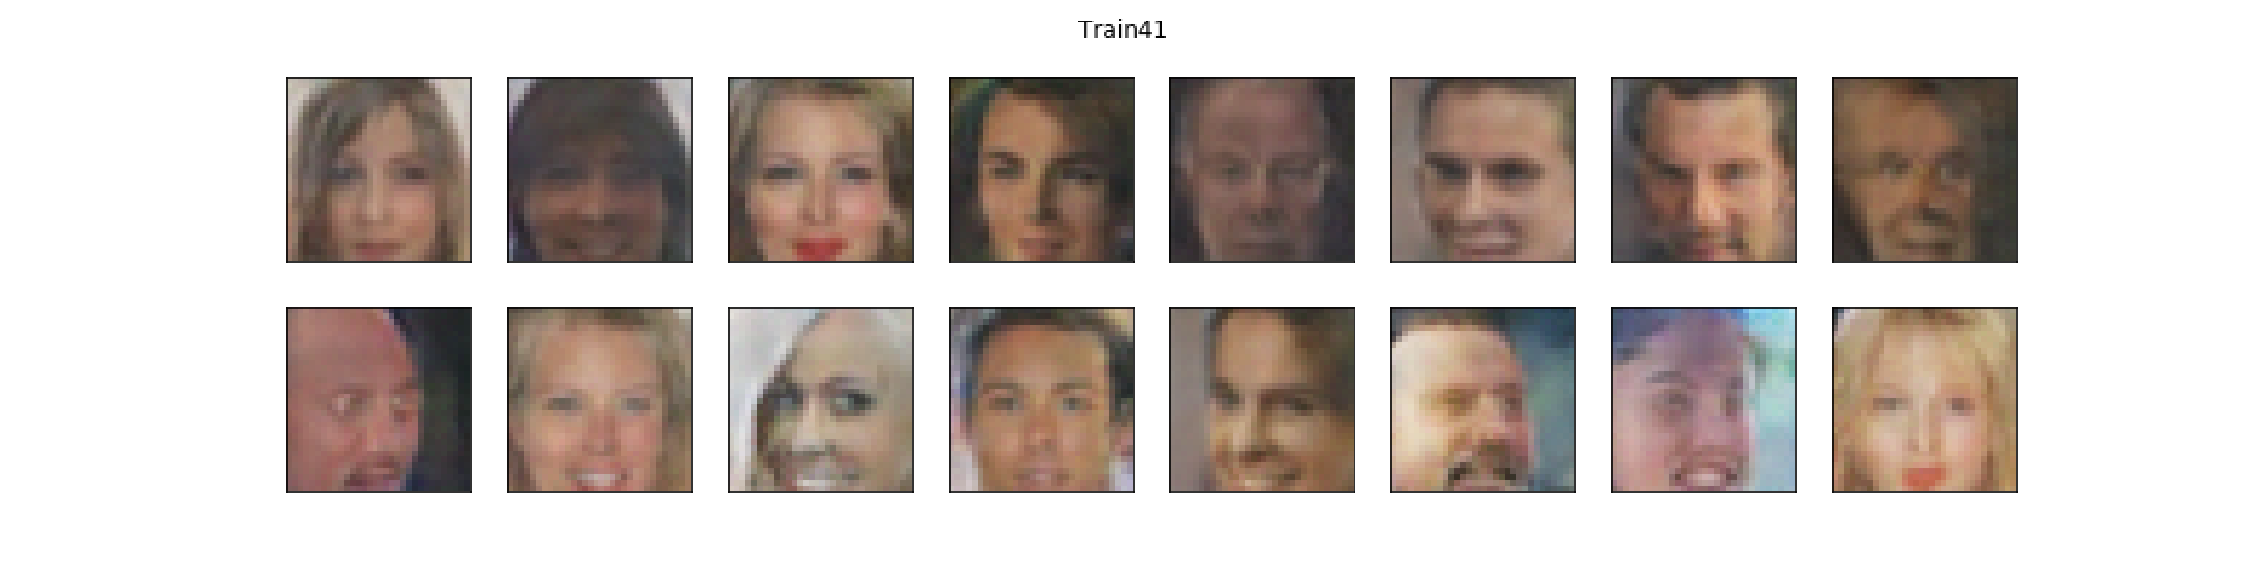

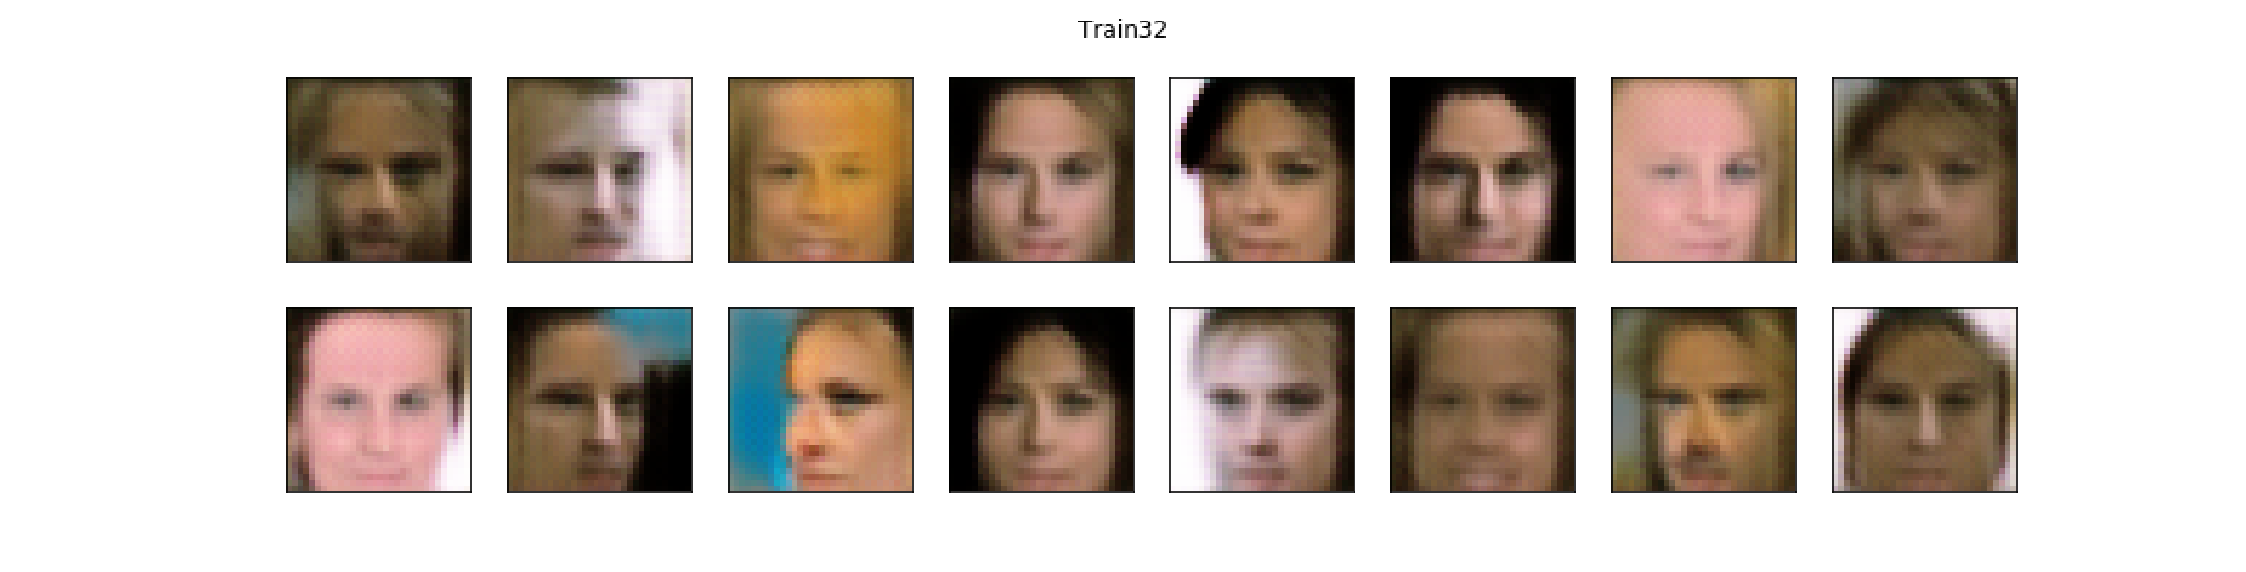

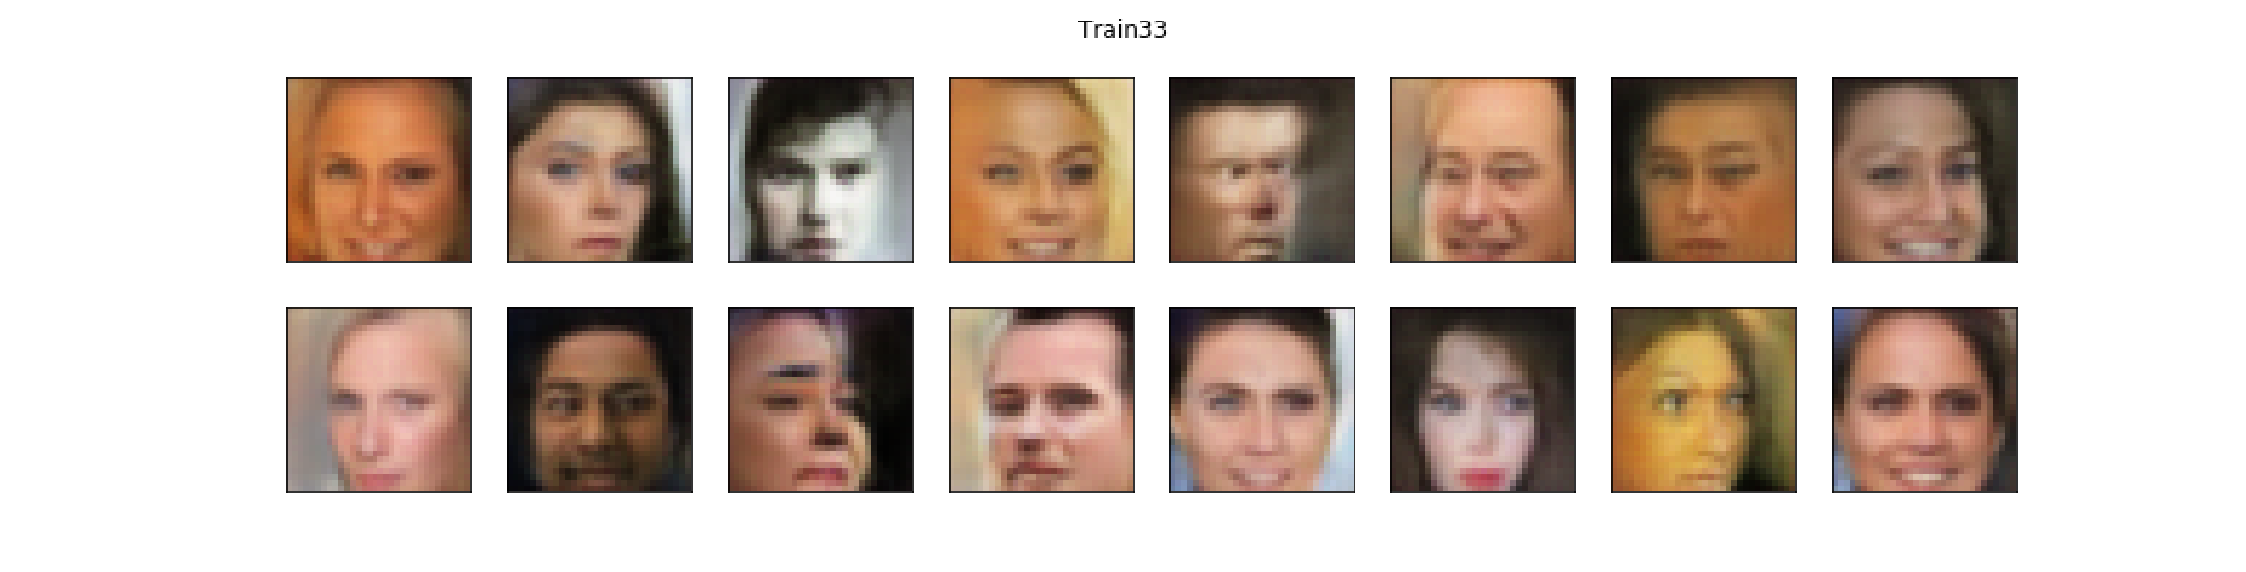

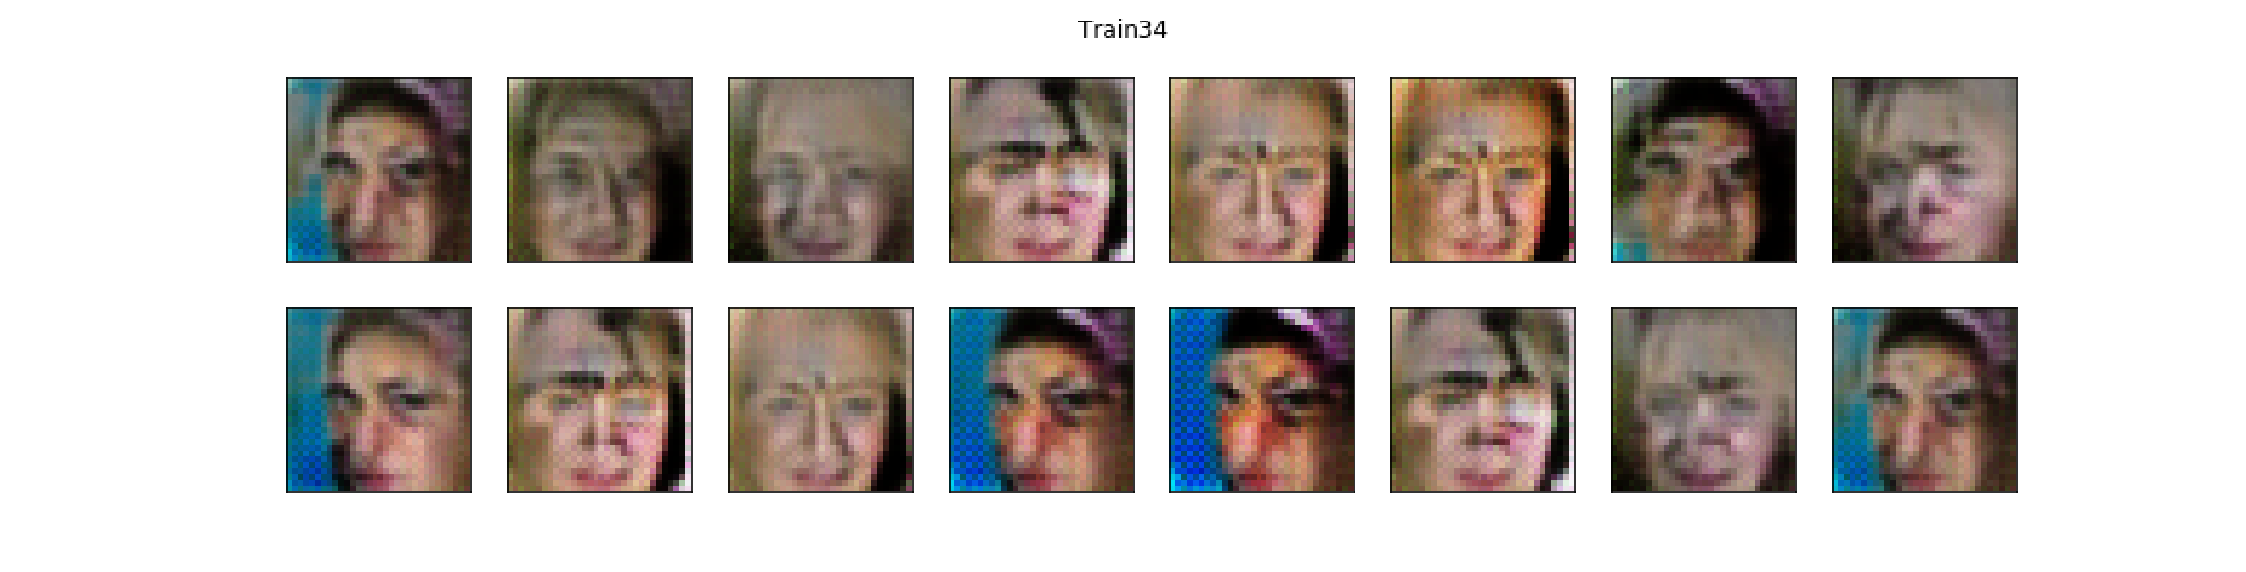

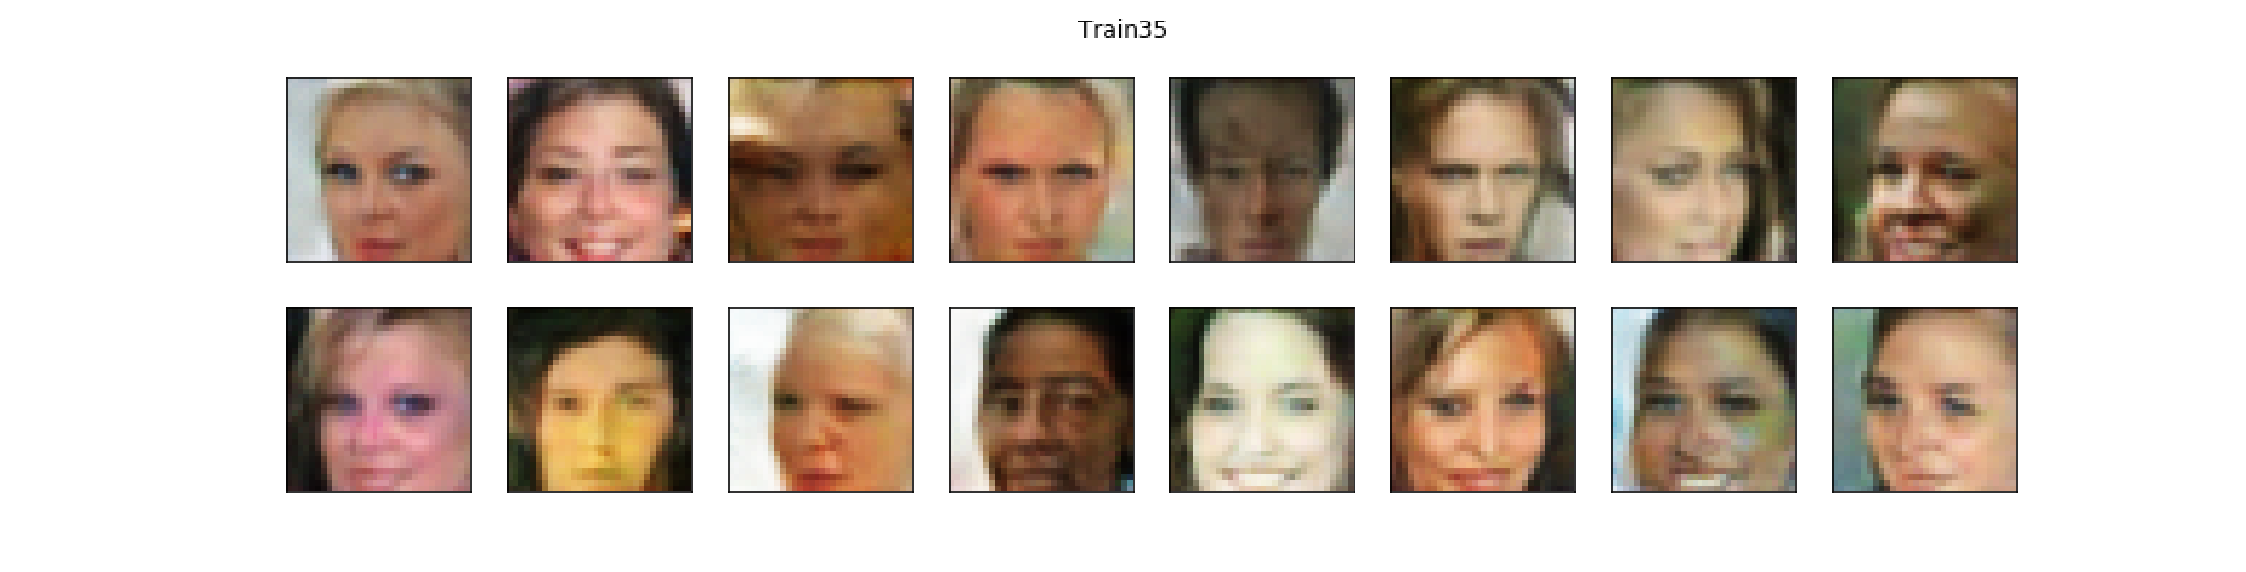

In [54]:
# dropout config
parameter_list_name = ['Train41', 'Train32', 'Train33', 'Train34', 'Train35']
train_num_list = [41, 32, 33, 34, 35]
param_list = ['drop', 'num_epochs', 'num_epochs', 'drop', 'drop']
epoch_list = [100, 100, 100, 100, 100]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

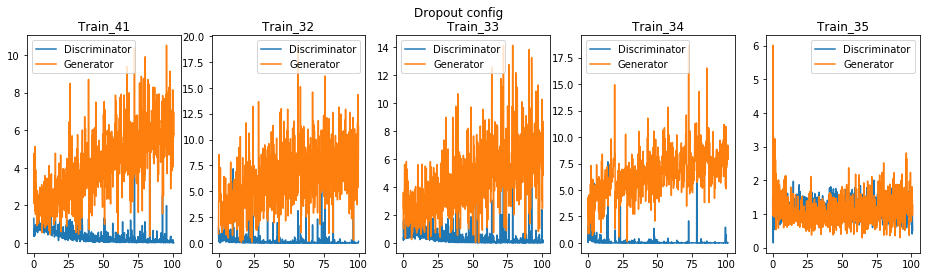

In [55]:
view_plots([[41, 'drop', 9],
            [32, 'num_epochs', 9],
            [33, 'num_epochs', 9],
            [34, 'drop', 9],
            [35, 'drop', 9]],'Dropout config', 'drop')  

### Result for Dropout config:
It turns out that applying droping layers can lead to a certain enhancement of the quality of generated images. Best dropout results were achieved for Train32 (and Train33), i.e. applying a dropout layer with a dropout probability of 0.5 (0.2) after each convolutional for the discriminator and each deconvolutional layer for the generator. However, even without any dropout layers the results are not bad (Train41).

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result

**Answer:** (Write your answer in this cell)

A whole bunch of parameters setting were tested in sequences (see evaluation above or click on the links below):

## Reasons for the chosen final hyperparameter setting:

### <a href='#Parameter_n_epochs'>Parameter: n_epochs</a>
n_epochs was varied between 1 and 500. Best value setting for the number of epochs extends to the range 20...70. Lower epoch values lead to underfitting, higher epoch values tend to pronounced noisy behavior of the discriminator loss. In both regimes the generated face images are blurred. 

### <a href='#Parameter_number_conv_deconv_layers'>Parameter: number of conv-layers and deconv-layers</a>
Two models were constructed: one with 3 and another one with 4 conv and deconv layers for the discriminator and generator, respectively. Corresponding images for conv-layers=deconv-layers=3 look similar to conv-layers=deconv-layers=4. Hence, a clear trend is hard to distinguish in these examples. However, the trend of losses is slightly better for conv-layers=deconv-layers=4 than for conv-layers=deconv-layers=3, i.e. the loss for the Generator is higher and the loss for the Discriminator is slightly lower. Therefore conv-layers=4 and deconv-layers=4 have been used for further parameter studies.

### <a href='#Parameter_conv_dim'>Parameter: conv_dim</a>
The conv_dim value was investigated in the range between 32 and 256. With a higher conv_dim for the Generator and the Discriminator the resolution of feature details is getting higher. For example, eyes are better resolved with a conv_dim=256 than with a conv_dim=32. However, even a conv_dim of 64 leads to convincing results.

### <a href='#Parameter_lr'>Parameter: lr</a>
Learning rates in the range between 0.01 and 0.0001 were tested. In all cases the GAN is able to learn and generated fake images of faces are successfully constructed. However, a learning rate of lr=0.0002 leads to best results. As the choice of batch_size has to be done with an appropriate learning rate, learning rates were also studied in combination with different values for <a href='#Parameter_batch_size'>batch_size</a> as well as for <a href='#Parameter_beta1'>beta1</a>.

### <a href='#Parameter_batch_size'>Parameter: batch_size</a>
The value range for the batch_size was chosen between 16 and 512. A larger batch_size has a positive effect on the computational boost. However, if the batch_size is getting too high the feature resolution is getting worse (more blurred). If the batch_size is too small, then the gradients will become more unstable and would need to reduce the learning rate. So batch_size and learning rate lr are linked. The noisy loss for small batch_sizes can be used to overcome local minima during training. If one use a bigger batch_size, then the gradients will become less noisy (this can be clearly seen in the results above) but it will take longer to converge. Therefore a batch_size of 32 has been chosen. Up to a batch_size of 512 no out-of-memory errors were observed.

### <a href='#Parameter_beta1'>Parameter: beta1</a>
Values for beta1 were investigated in the range between 0.1 to 0.5. It was found out that beta1 values in the range between 0.1 to 0.3 have shown to get best results for generated images.

### <a href='#Parameter_dropout'>Parameter: Dropout config</a>
It turns out that applying droping layers can lead to a certain enhancement of the quality of generated images. Best dropout results were achieved for Train32 (and Train33), i.e. applying a dropout layer with a dropout probability of 0.5 (0.2) after each convolutional for the discriminator and each deconvolutional layer for the generator. However, even without any dropout layers the results are not bad (Train41).

### Further improvements:
- To overcome the issue of a biased dataset (celebrity faces that are mostly white): one could add more images of non-white celebrity faces to get a more balanced dataset in the end.
    
- The model size is limited by the number of conv-layers and deconv-layers which was set to 4 in maximum. Higher values were not tested so far. Increasing the model size could especially enhance the feature extraction of the Discriminator. The adversarial Generator is then forced to produce images with better feature resolution.

- A further increase of the conv_dim could lead to better results. However, this would significantly increase the training time.

- The dataset images are 64x64x3 NumPy images. In the get_dataloader function I resized the images down to 32x32x3. This is the image size for the Discriminator input and the size of the Generator output. This resolution of the generated images is noisy. If one would keep width=64 and height=64 the images could resemble more the original ones. However, this would also increase the training duration.

- Regarding the optimizer strategy: For the Discriminator as well as for the Generator the same type of optimizer (Adam) was chosen with a learning rate down to 0.0001. A combination of different optimizer like SGD for the Discriminator and Adam for the Generator as proposed by [Soumith](https://github.com/soumith/ganhacks) has not been tested yet.

### Final hyperparameter setting
The following table shows the best-of setting of the investigated parameter tuning.

Parameters          | 41th Train-Run|
----------          | ------------- |
batch_size          |   32          |  
img_size            |   32          |  
deconv-layers       |   4           |  
conv-layers         |   4           |  
d_conv_dim          |   64          |    
g_conv_dim          |   64          |  
z_size              |   100         |  
lr                  |   0.0002      |   
beta1               |   0.2         |   
beta2               |   0.999       |     
dropout             |   no          |   
n_epochs            |   70          | 

### Final fake image output

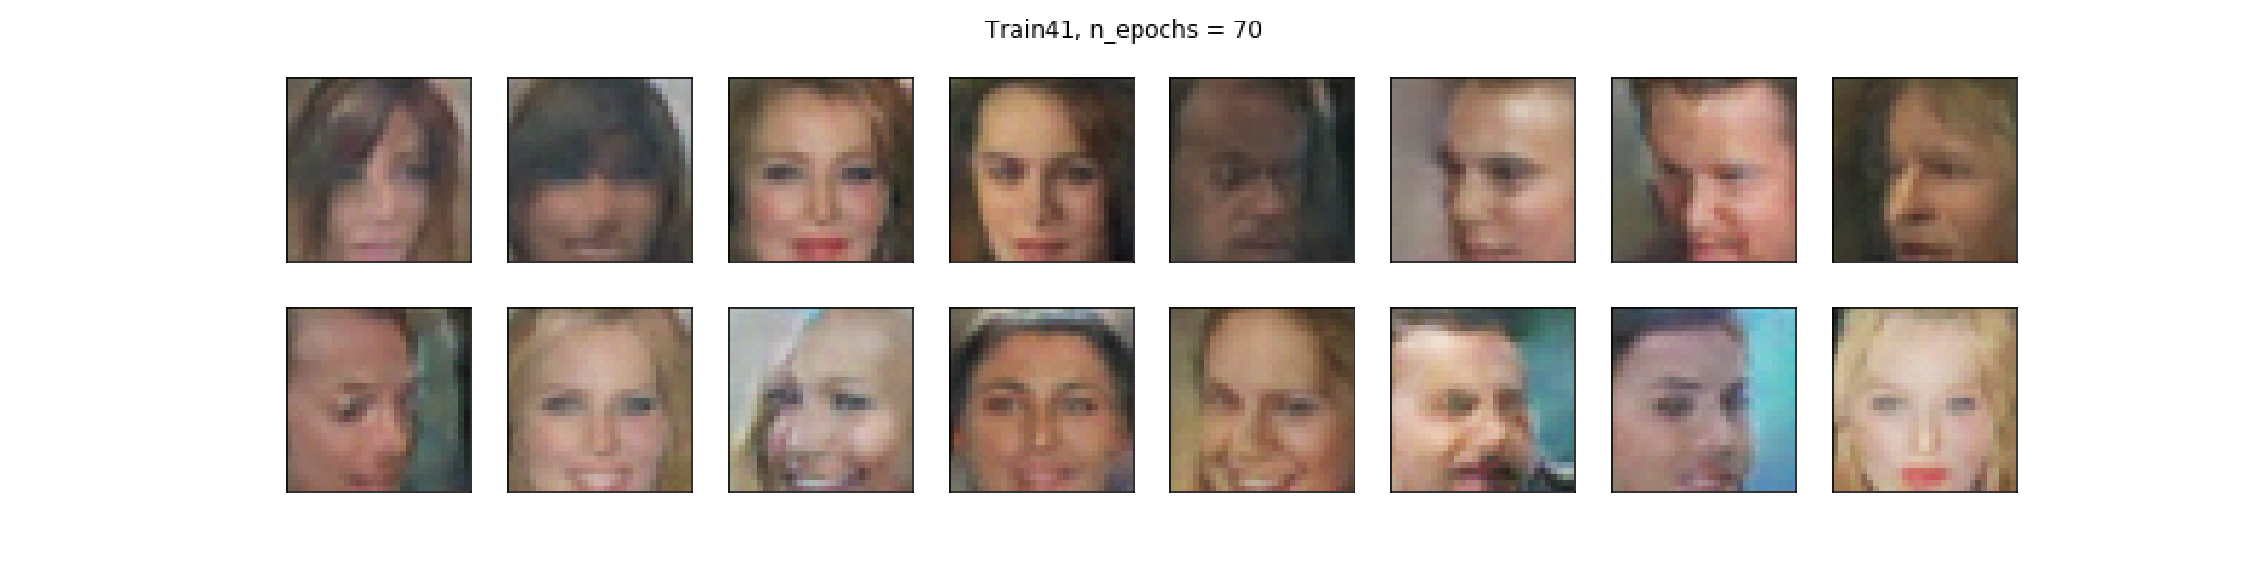

In [72]:
# final result
# n_epochs = 70
parameter_list_name = ['Train41, n_epochs = 70']
train_num_list = [41]
param_list = ['drop']
epoch_list = [70]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

Click here to see the whole n_epochs series of this training run
### <a href='#Parameter_n_epochs'>Parameter: n_epochs</a>

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.